In [2]:
import numpy as np
import matplotlib.pyplot as plt

def histParam_kin(p_names,names,data,filename):
    for name in p_names:
        var_names = ["px","py","pz"]
        data_mom = data[names == name,5:]
        for j, var_name in enumerate(var_names):
            plt.figure()
            plt.hist(data_mom[:,j], bins=100)
            plt.xlabel(f'{var_name} (keV)', size = 14)
            plt.ylabel('Counts', size = 14)
            plt.tick_params('both', labelsize = 14) 
            #plt.yscale('log')
            plt.tight_layout()
            plt.savefig(f'{name}_{var_name}.pdf')
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        data_E = data[names == name,4]
        data_v = data_mom/data_E[:,np.newaxis]
        var_names2 = ["vx","vy","vz"]
        for j, var_name in enumerate(var_names2):
            plt.figure()
            plt.hist(data_v[:,j], bins=100)
            plt.xlabel(f'{var_name} (c)', size = 14)
            plt.ylabel('Counts', size = 14)
            plt.tick_params('both', labelsize = 14) 
            #plt.yscale('log')
            plt.tight_layout()
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        if name in ['e+','e-']:
            data_dir = data_v/np.tile(np.linalg.norm(data_v,axis=1),(3,1)).T
            var_names3 = ["x_dir","y_dir","z_dir"]
            for j, var_name in enumerate(var_names3):
                plt.figure()
                plt.hist(data_dir[:,j], bins=100)
                plt.xlabel(f'{var_name}', size = 14)
                plt.ylabel('Counts', size = 14)
                plt.tick_params('both', labelsize = 14) 
                #plt.yscale('log')
                plt.tight_layout()
                plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')

    chargedl_data = data[np.logical_or(names == 'e+',names == 'e-'),5:8]
    neutrino_data = data[np.logical_or(names == 'enu',names == 'enubar'),5:8]
    chargedl_data = chargedl_data/np.tile(np.linalg.norm(chargedl_data,axis=1),(3,1)).T
    neutrino_data = neutrino_data/np.tile(np.linalg.norm(neutrino_data,axis=1),(3,1)).T
    angle = np.sum(chargedl_data*neutrino_data,axis=1)
    plt.figure()
    plt.hist(angle, bins=100)
    plt.xlabel('cos(theta_{e,enu})')
    plt.ylabel('Counts')
    #plt.yscale('log')
    plt.savefig(f'plots/{filename[6:-4]}_angular_correlation_enu_e.pdf')

In [3]:
mass_e = 510.9989461

class data_analysis:
    def __init__(self,fileName,betaType):
        data = np.genfromtxt(fileName, dtype=str)
        self.names = data[:,2]
        self.data = data[:, np.arange(data.shape[1]) != 2].astype(dtype=np.float32)
        self.events = data[:,0].astype(int)
        self.data[np.isnan(self.data)] = 0
        self.c_lepton = "e-" if (betaType == 1) else "e+"
        self.neutrino = "enubar" if (betaType == 1) else "enu"
    def __len__(self):
        return self.data.shape[0]
    def event_mask(self):
        pass
    def kinematical_data(self):
        #energy
        self.data_E_el = self.data[self.names == self.c_lepton ,4]
        
        #directions
        self.data_dir_el = self.data[self.names == self.c_lepton ,5:8]
        self.data_dir_el /= np.tile(np.linalg.norm(self.data_dir_el,axis=1),(3,1)).T
        self.data_dir_enu = self.data[self.names == self.neutrino ,5:8]
        self.data_dir_enu /= np.tile(np.linalg.norm(self.data_dir_enu,axis=1),(3,1)).T
        
        #angle between e and enu
        self.data_angle_elenu = np.sum(self.data_dir_el*self.data_dir_enu,axis=1)
     
    def kinematical_data_ref(self,polDir = np.array([0,0,1])):
        #angles in reference to polDir
        z_cross_elenu = np.sum(np.cross(self.data_dir_el,self.data_dir_enu)*polDir[np.newaxis,:],axis=1)
        self.cos_el = np.sum(self.data_dir_el*polDir[np.newaxis,:],axis=1)
        self.cos_enu = np.sum(self.data_dir_enu*polDir[np.newaxis,:],axis=1)
        sin_el = np.sqrt(1-self.cos_el**2)
        sin_enu = np.sqrt(1-self.cos_enu**2)
        data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)/sin_el/sin_enu
        data_sinphi = z_cross_elenu/sin_el/sin_enu
        self.data_phi = np.arctan2(data_sinphi,data_cosphi)
    def plot_E_dist(self):
        print(self.data_E_el.size)
        plt.hist(self.data_E_el, bins=100)
        plt.xlabel('E')
        plt.ylabel('Counts')
        #plt.yscale('log')
        plt.title("e-")
        plt.show()
    def theoretical_dist(self, coeffs):
        #note a, c, A, B and D need to be functions dependent on energy
        E_hist, E_bin = np.histogram(self.data_E_el, bins= 200)
        E_vals = (E_bin[1:]+E_bin[:-1])/2
        N = self.data_E_el.size

        z_el = np.linspace(-1,1,201)
        z_nu = z_el.copy()
        z_elenu = z_el.copy()
        phi = np.linspace(-np.pi,np.pi,501)

        self.z_el = z_el
        self.z_nu = z_nu
        self.z_elenu = z_elenu
        self.phi = phi
        
        self.z_el_theory = np.zeros_like(z_el)
        self.z_nu_theory = np.zeros_like(z_nu)
        self.z_elenu_theory = np.zeros_like(z_elenu)
        self.phi_theory = np.zeros_like(phi)

        for E, dist in zip(E_vals, E_hist):
            a, b, c, A, B, D = coeffs(E)
            beta = np.sqrt(1-mass_e**2/E**2)
            self.z_el_theory += dist/N*(1+b*mass_e/E+A*beta*z_el)/2/(1+b*mass_e/E) 
            self.z_elenu_theory += dist/N*(1+b*mass_e/E+a*beta*z_elenu)/2/(1+b*mass_e/E)
            self.z_nu_theory += dist/N*(1+b*mass_e/E+B*z_nu)/2/(1+b*mass_e/E)
            phi_theory_E = dist/N*(1 + b*mass_e/E + beta*((a+c/3)*np.cos(phi)+D*np.sin(phi))*(np.pi/4)**2)
            self.phi_theory += phi_theory_E/2/np.pi/(1+b*mass_e/E)

    def plot_kin_histograms(self,fileName):
        p_names = (set(self.names)&{'e+','e-','enubar','enu'})
        histParam_kin(p_names,self.names,self.data,fileName)
        plt.show()
    def plot_distribution_histograms(self,showTheory,bins=100,fileName=None):
        fig, axs = plt.subplots(2,2,figsize=(10,7))
        for ax in axs.flatten():
            ax.tick_params('both',labelsize = 14)
        axs[0,0].hist(self.cos_el, bins=bins,density=True) #z component
        if showTheory:
            axs[0,0].plot(self.z_el,self.z_el_theory,linewidth = 2)
        axs[0,0].set_xlabel("$\\cos \\theta_{e,j}$",size = 16)
        axs[0,0].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[1,0].hist(self.cos_enu, bins=bins,density=True) #z component
        if showTheory: 
            axs[1,0].plot(self.z_nu,self.z_nu_theory,linewidth = 2)
        axs[1,0].set_xlabel("$\\cos \\theta_{\\nu,j}$",size = 16)
        axs[1,0].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[0,1].hist(self.data_angle_elenu, bins=bins,density=True)
        if showTheory: 
            axs[0,1].plot(self.z_elenu,self.z_elenu_theory,linewidth = 2)
        axs[0,1].set_xlabel("$\\cos \\theta_{e,\\nu}$",size = 16)
        axs[0,1].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[1,1].hist(self.data_phi, bins=bins,density=True)
        if showTheory: 
            axs[1,1].plot(self.phi,self.phi_theory,linewidth = 2)
        axs[1,1].set_xlabel("$\\phi$",size = 16)
        axs[1,1].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        fig.tight_layout()
        if fileName != None:
            fig.savefig(f"plots/{fileName}.png")
        plt.show()

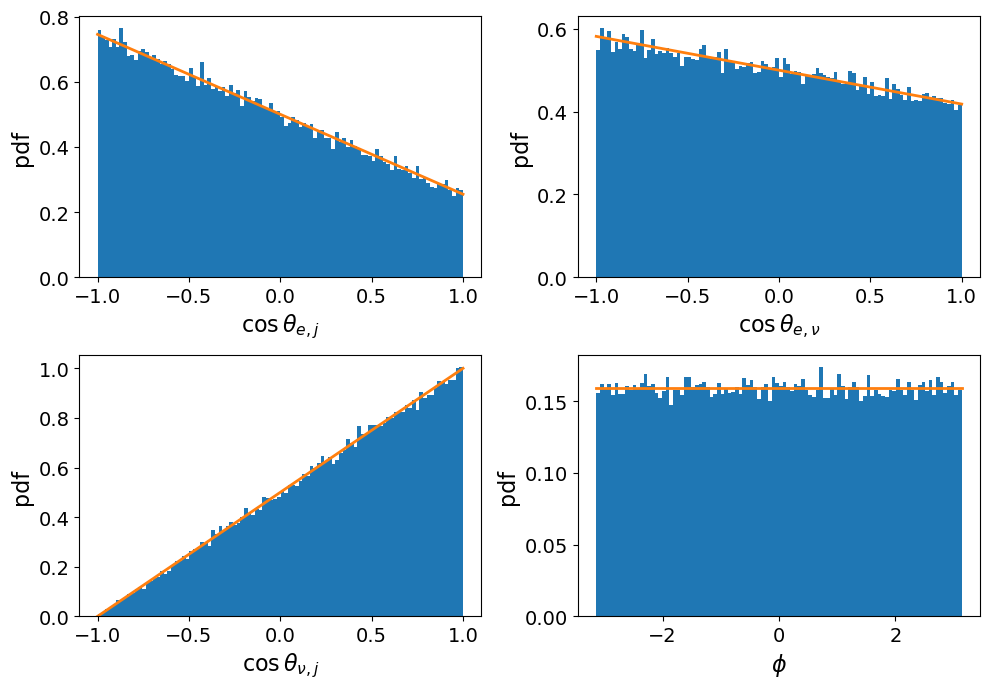

In [4]:
class Co60_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, 1)
    def event_mask(self):
        part_events = np.bincount(self.events)
        events_mask = np.arange(part_events.size)[part_events == 5] #60Ni + e- + enu + 2 gamma
        self.data = self.data[np.isin(self.events, events_mask),:]
        self.names = self.names[np.isin(self.events, events_mask)]
    
#Standard Model Gamov-Teller

def SM_coeffs(E):
    return (-1/3, 0, 1, -1, 1, 0)
   
SM_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos.txt")
SM_60Co_polZpos.event_mask()
SM_60Co_polZpos.kinematical_data()
SM_60Co_polZpos.kinematical_data_ref()
SM_60Co_polZpos.theoretical_dist(SM_coeffs)
SM_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="60Co_SM_hists")

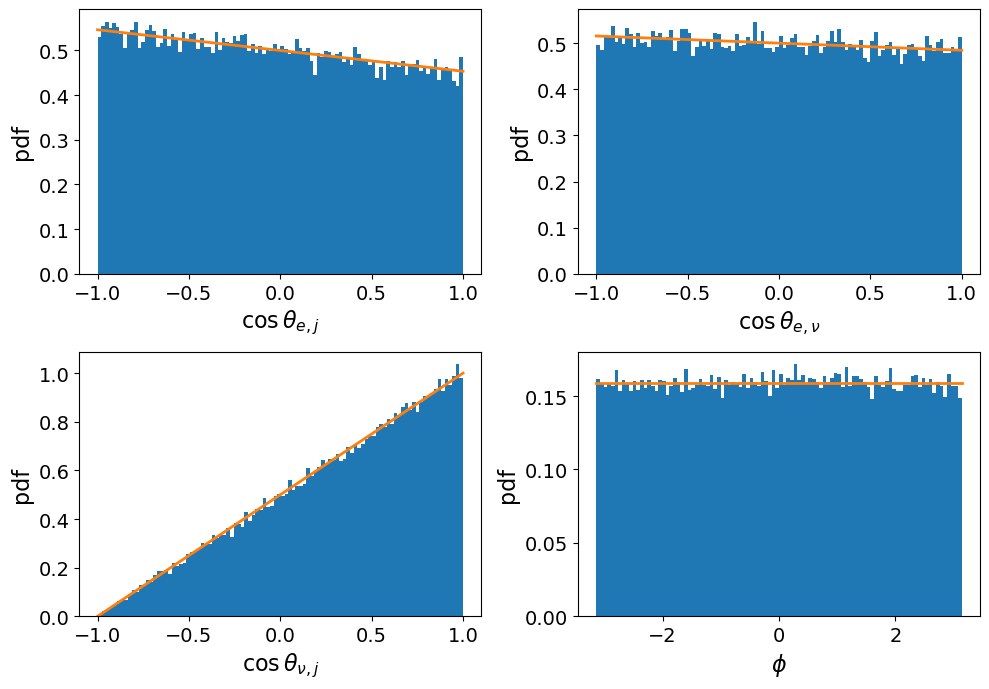

In [21]:
#Gamov-Teller with C_T = C_T' = 1/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

def CTposRe_coeffs(E):
    a = -1/3*(1/3)
    c = 1/3
    A = -1/3
    b = 2/3*gamma*np.sqrt(2)
    B = 2/3*(1.5+gamma*mass_e/E*np.sqrt(2))
    return (a, b, c, A, B, 0)
   
CTposre_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos_ctposRe.txt")
CTposre_60Co_polZpos.event_mask()
CTposre_60Co_polZpos.kinematical_data()
CTposre_60Co_polZpos.kinematical_data_ref()
CTposre_60Co_polZpos.theoretical_dist(CTposRe_coeffs)
CTposre_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="60Co_CTposRe_hists")

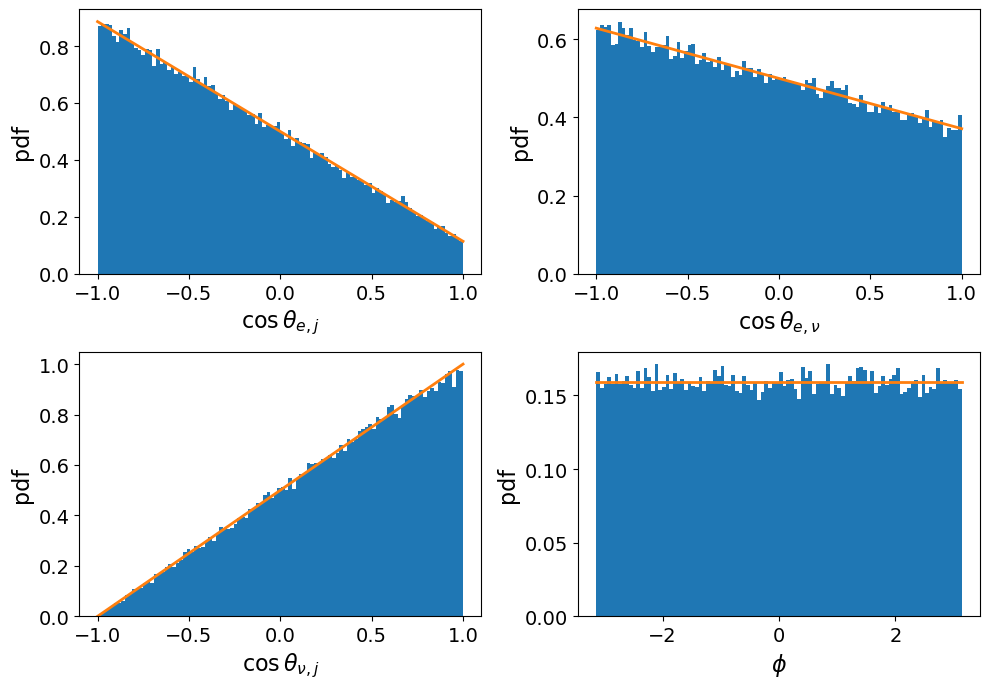

In [22]:
#Gamov-Teller with C_T = C_T' = -1/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

def CTnegRe_coeffs(E):
    a = -1/3*(1/3)
    c = 1/3
    A = -1/3
    b = -2/3*gamma*np.sqrt(2)
    B = 2/3*(1.5-gamma*mass_e/E*np.sqrt(2))
    return (a, b, c, A, B, 0)
   
CTnegRe_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos_ctnegRe.txt")
CTnegRe_60Co_polZpos.event_mask()
CTnegRe_60Co_polZpos.kinematical_data()
CTnegRe_60Co_polZpos.kinematical_data_ref()
CTnegRe_60Co_polZpos.theoretical_dist(CTnegRe_coeffs)
CTnegRe_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="60Co_CTnegRe_hists")

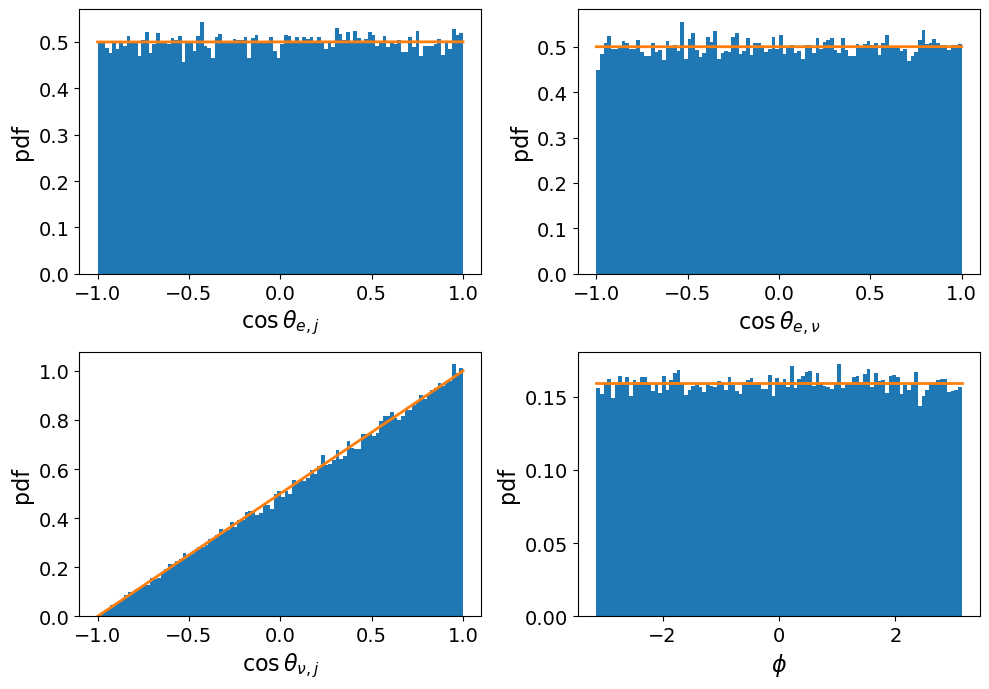

In [23]:
#Gamov-Teller with C_T = C_T' = i/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

def CTposIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    a = 1/3*(1/3)*(-1+2*coulombCorr*np.sqrt(2))
    c = -1/3*(-1+2*coulombCorr*np.sqrt(2))
    A = 1/3*(-1+2*coulombCorr*np.sqrt(2))
    b = 0
    B = 1
    return (a, b, c, A, B, 0)
   
CTposIm_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos_ctposIm.txt")
CTposIm_60Co_polZpos.event_mask()
CTposIm_60Co_polZpos.kinematical_data()
CTposIm_60Co_polZpos.kinematical_data_ref()
CTposIm_60Co_polZpos.theoretical_dist(CTposIm_coeffs)
CTposIm_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="60Co_CTposIm_hists")

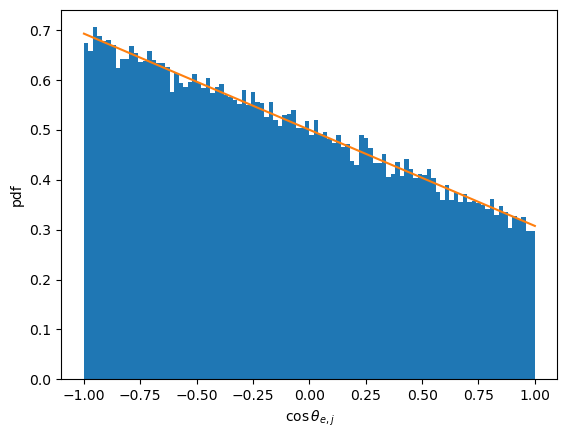

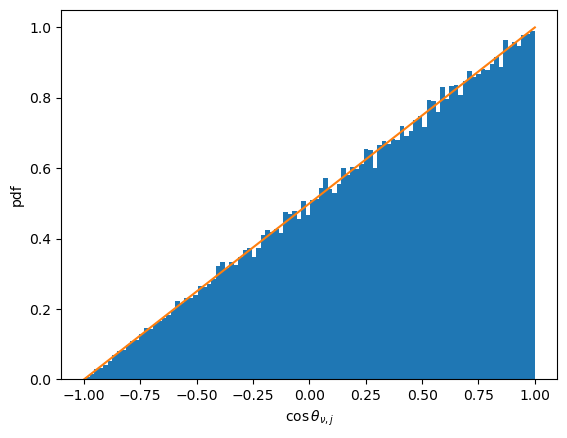

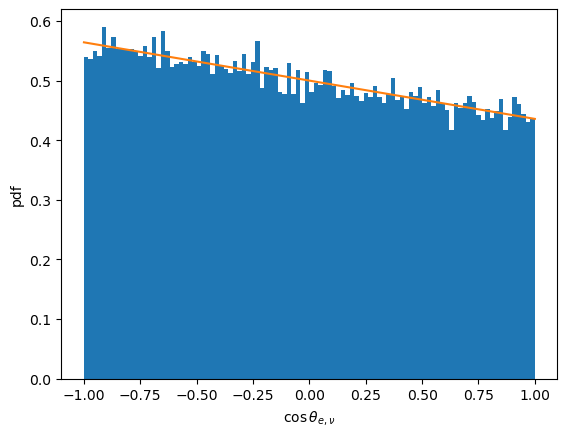

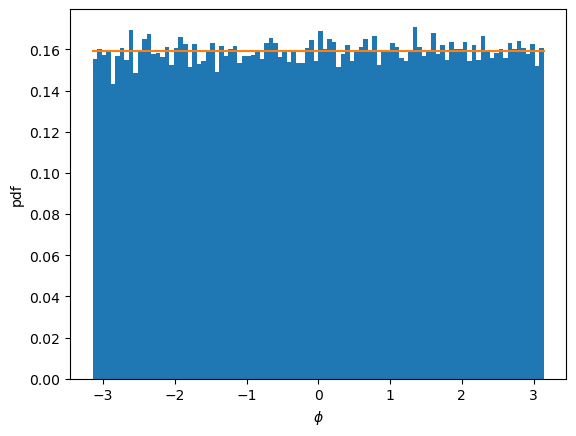

In [7]:
#Gamov-Teller with C_T = C_T' = 0.2i, C_A = C_A' = 1
#xi = 2.08

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

def CTposImS_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    a = 1/2.08*(1/3)*(-1.92+2*coulombCorr*0.4)
    c = -1/2.08*(-1.92+2*coulombCorr*0.4)
    A = 1/2.08*(-1.92+2*coulombCorr*0.4)
    b = 0
    B = 1
    return (a, b, c, A, B, 0)
   
CTposImS_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos_ctposImS.txt")
CTposImS_60Co_polZpos.event_mask()
CTposImS_60Co_polZpos.kinematical_data()
CTposImS_60Co_polZpos.kinematical_data_ref()
CTposImS_60Co_polZpos.theoretical_dist(CTposImS_coeffs)
CTposImS_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100)

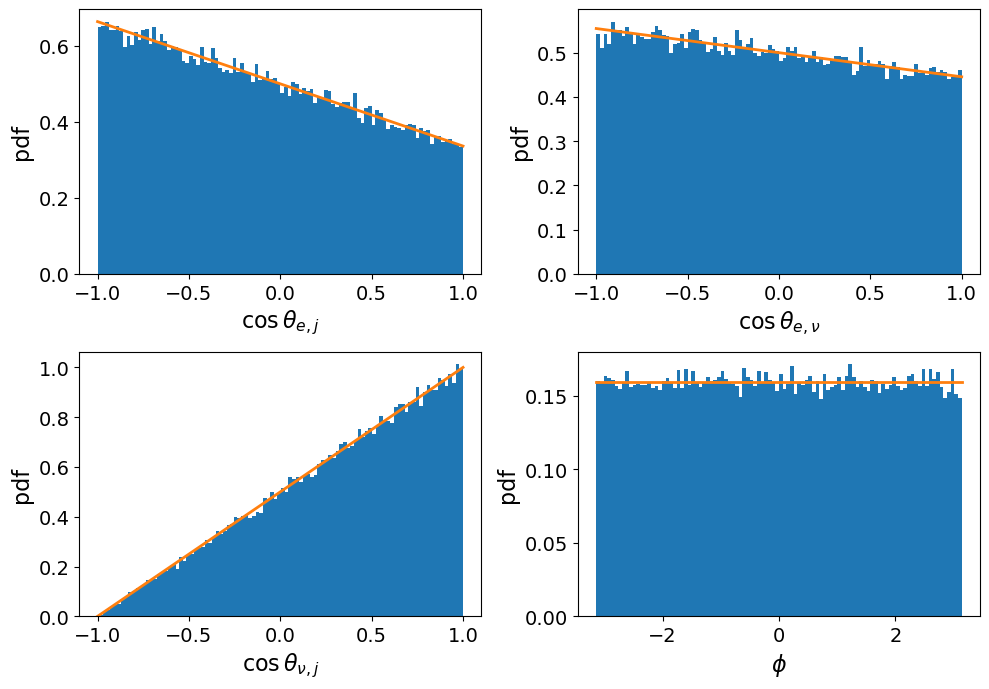

In [24]:
#Gamov-Teller with C_T = C_T' = -i/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

def CTnegIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    a = 1/3*(1/3)*(-1-2*coulombCorr*np.sqrt(2))
    c = -1/3*(-1-2*coulombCorr*np.sqrt(2))
    A = 1/3*(-1-2*coulombCorr*np.sqrt(2))
    b = 0
    B = 1
    return (a, b, c, A, B, 0)
   
CTnegIm_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos_ctnegIm.txt")
CTnegIm_60Co_polZpos.event_mask()
CTnegIm_60Co_polZpos.kinematical_data()
CTnegIm_60Co_polZpos.kinematical_data_ref()
CTnegIm_60Co_polZpos.theoretical_dist(CTnegIm_coeffs)
CTnegIm_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="60Co_CTnegIm_hists")

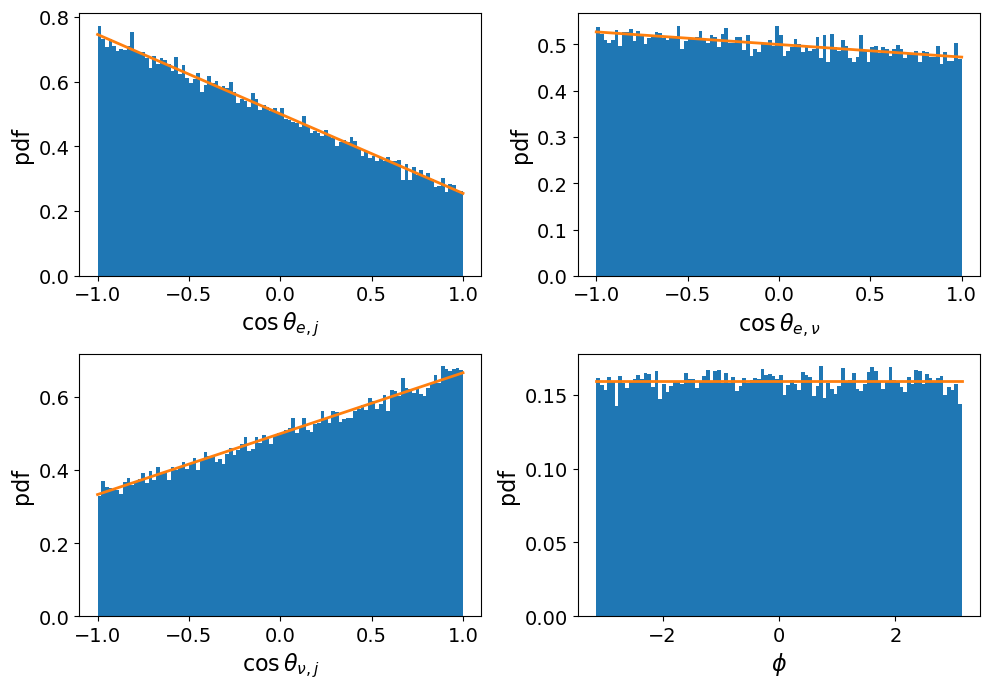

In [33]:
#Gamov-Teller with C_T = i/np.sqrt(2), C_T = -i/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

def CTmixRe_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    a = 1/3*(1/3)*(-1)
    c = -1/3*(-1)
    A = 1/3*(-3)
    b = 0
    B = 1/3
    return (a, b, c, A, B, 0)
   
CTmixIm_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos_CTmixRe.txt")
CTmixIm_60Co_polZpos.event_mask()
CTmixIm_60Co_polZpos.kinematical_data()
CTmixIm_60Co_polZpos.kinematical_data_ref()
CTmixIm_60Co_polZpos.theoretical_dist(CTmixRe_coeffs)
CTmixIm_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="60Co_CTmixRe_hists")

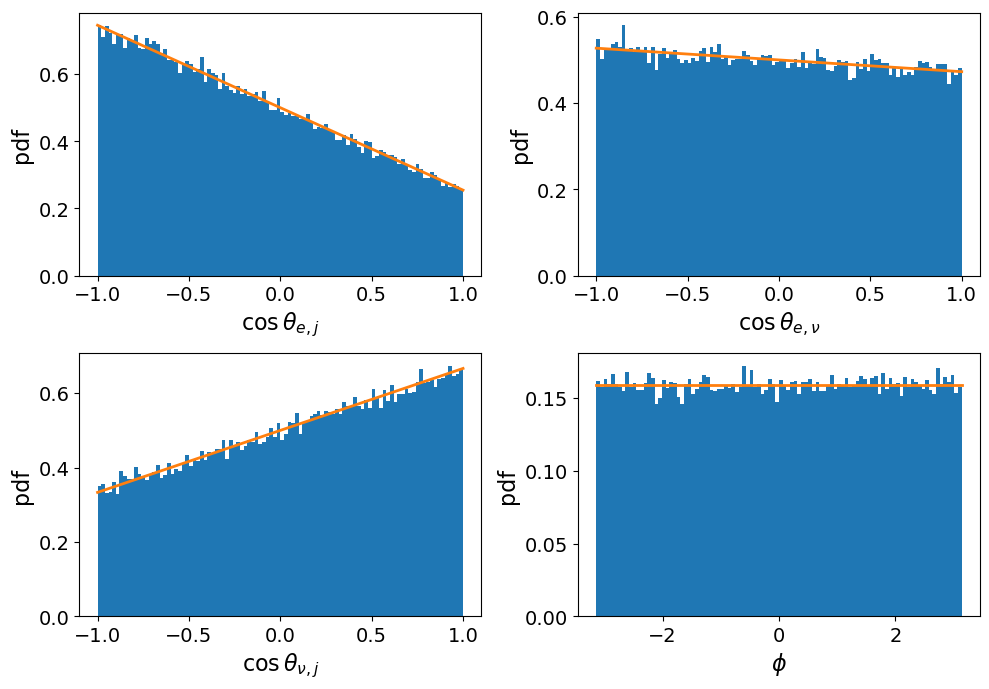

In [25]:
#Gamov-Teller with C_T = i/np.sqrt(2), C_T = -i/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

def CTmixIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    a = 1/3*(1/3)*(-1)
    c = -1/3*(-1)
    A = 1/3*(-3)
    b = 0
    B = 1/3
    return (a, b, c, A, B, 0)
   
CTmixIm_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos_ctmixIm.txt")
CTmixIm_60Co_polZpos.event_mask()
CTmixIm_60Co_polZpos.kinematical_data()
CTmixIm_60Co_polZpos.kinematical_data_ref()
CTmixIm_60Co_polZpos.theoretical_dist(CTmixIm_coeffs)
CTmixIm_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="60Co_CTmixIm_hists")

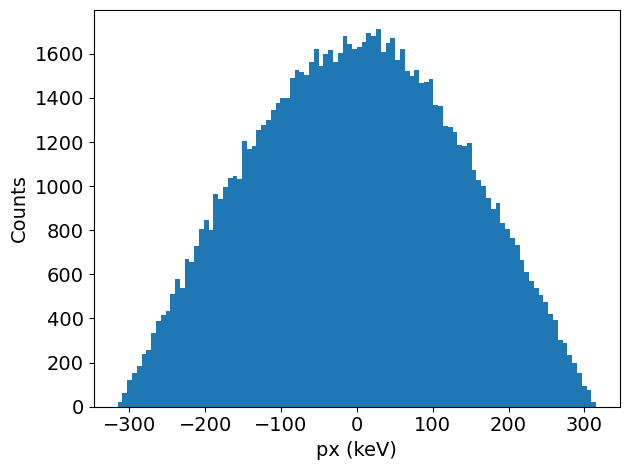

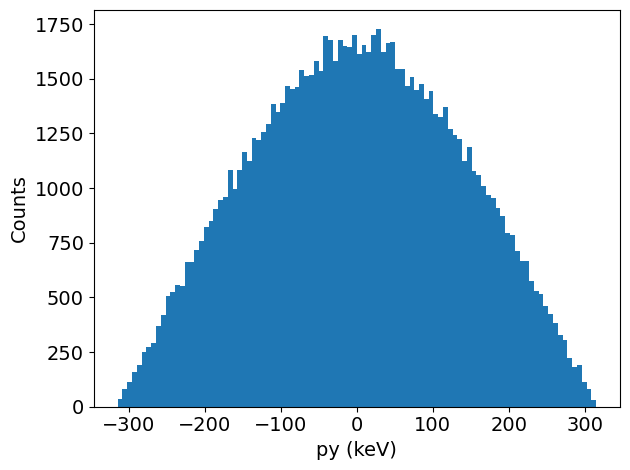

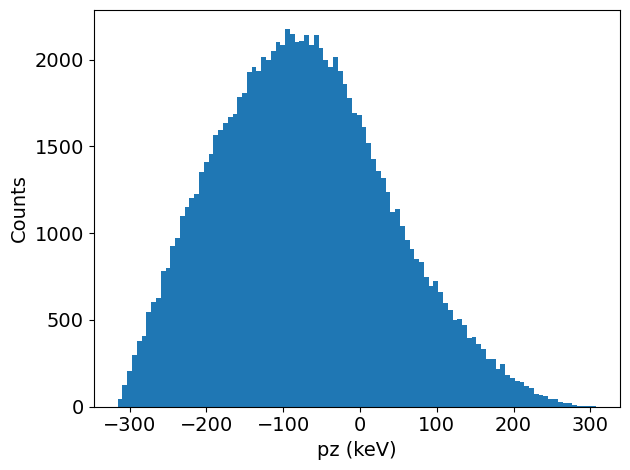

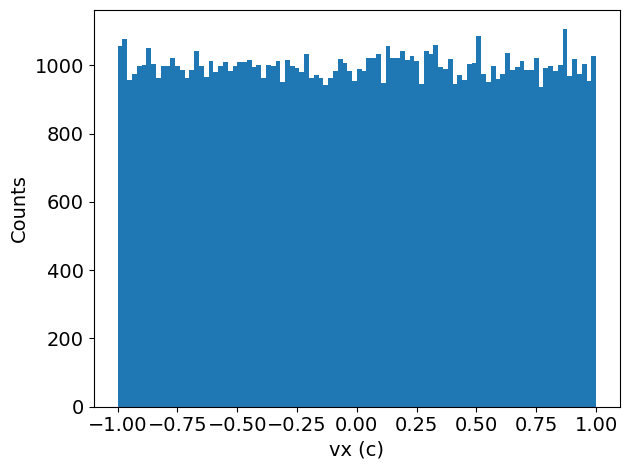

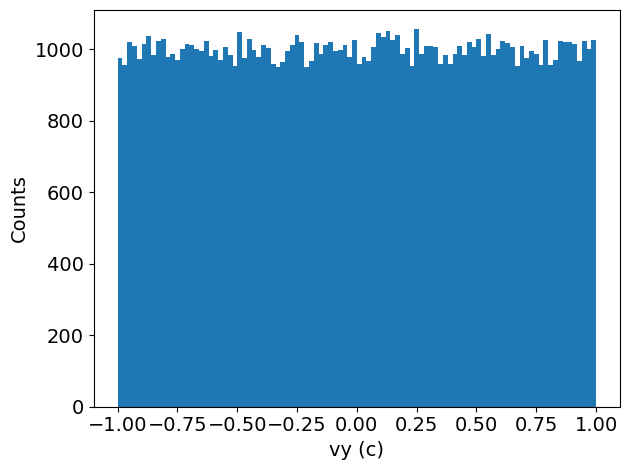

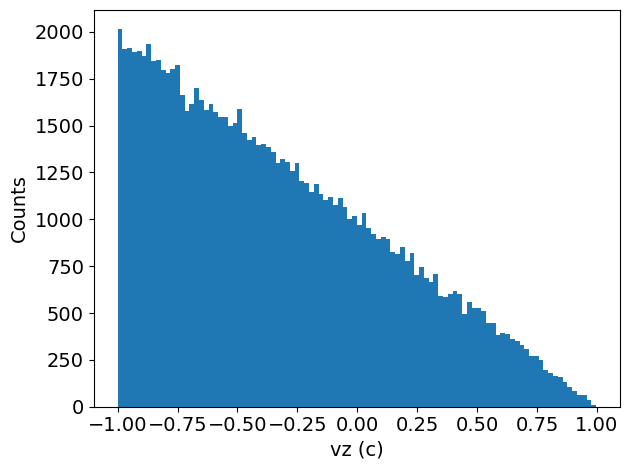

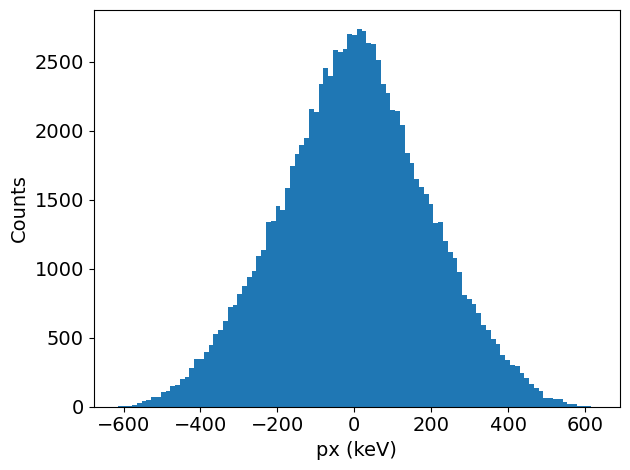

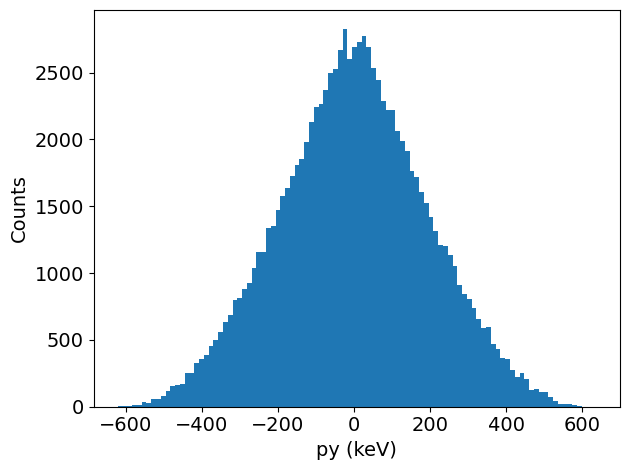

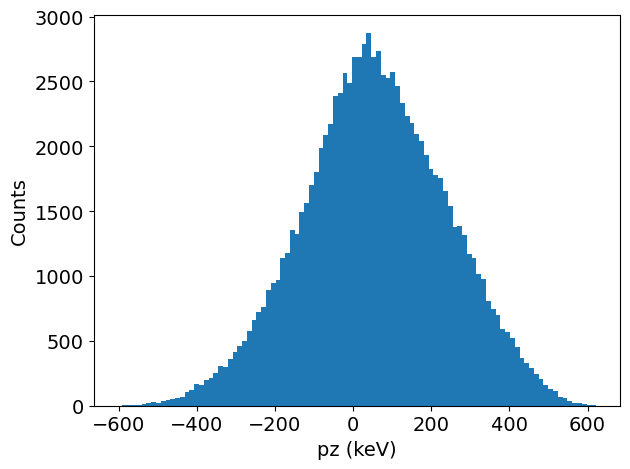

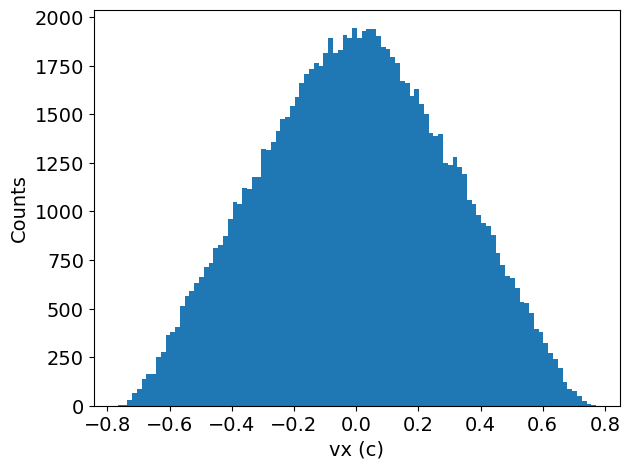

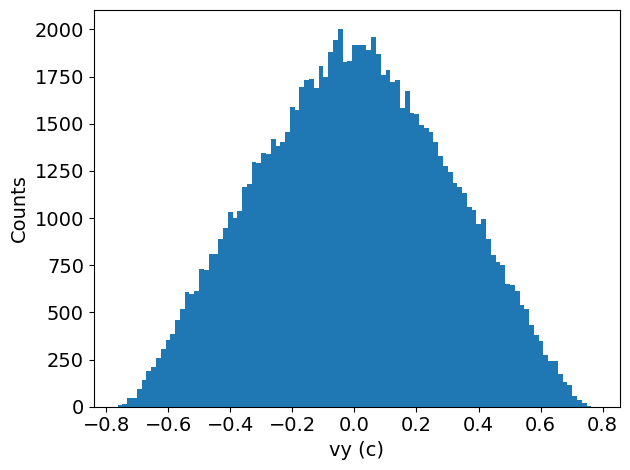

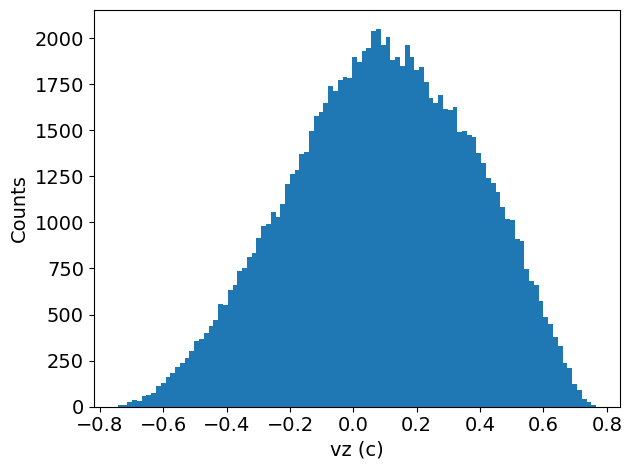

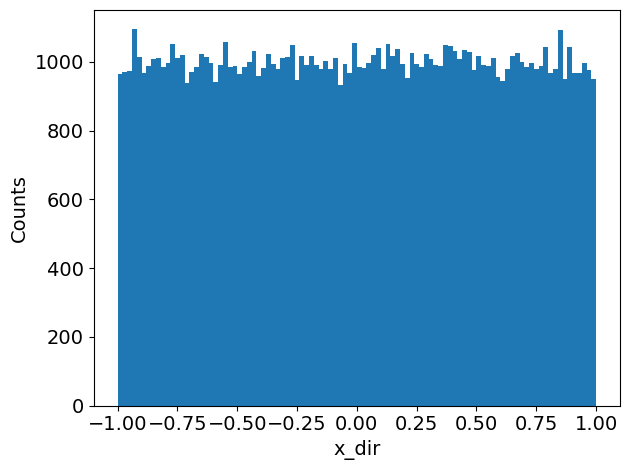

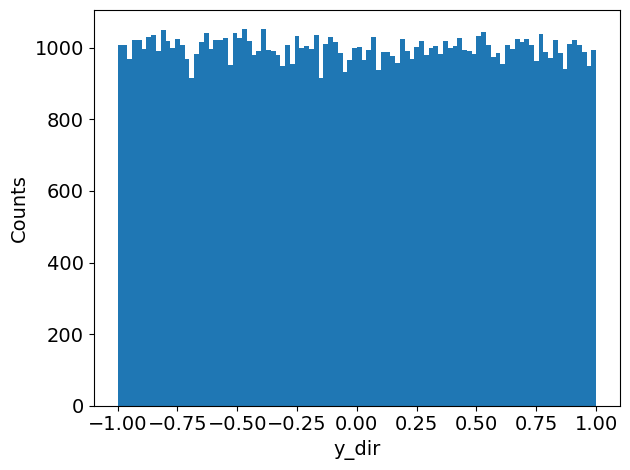

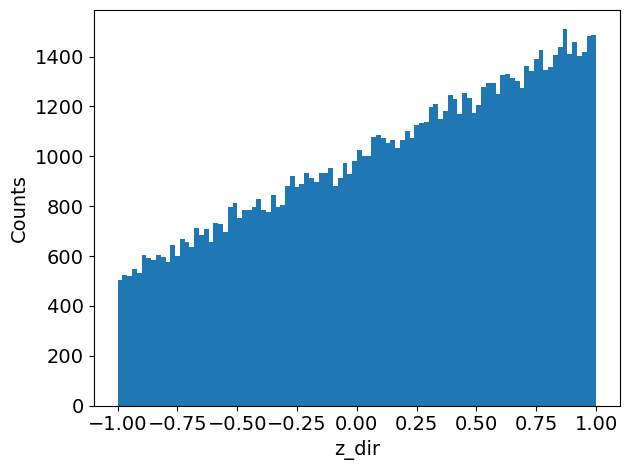

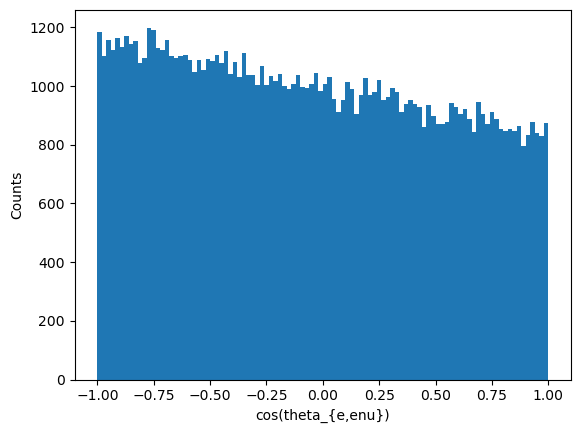

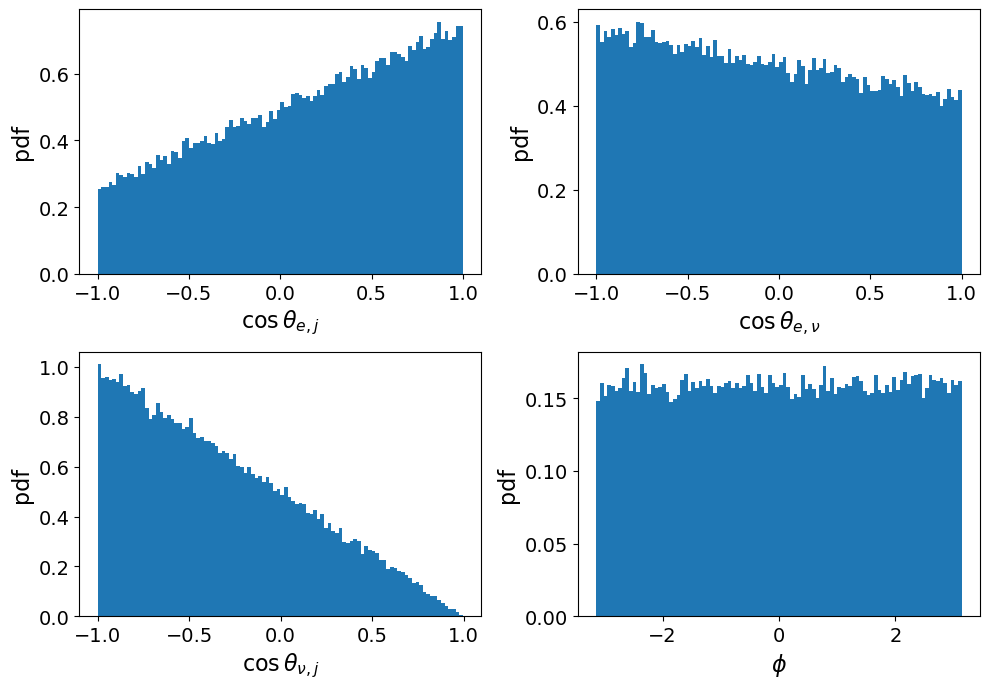

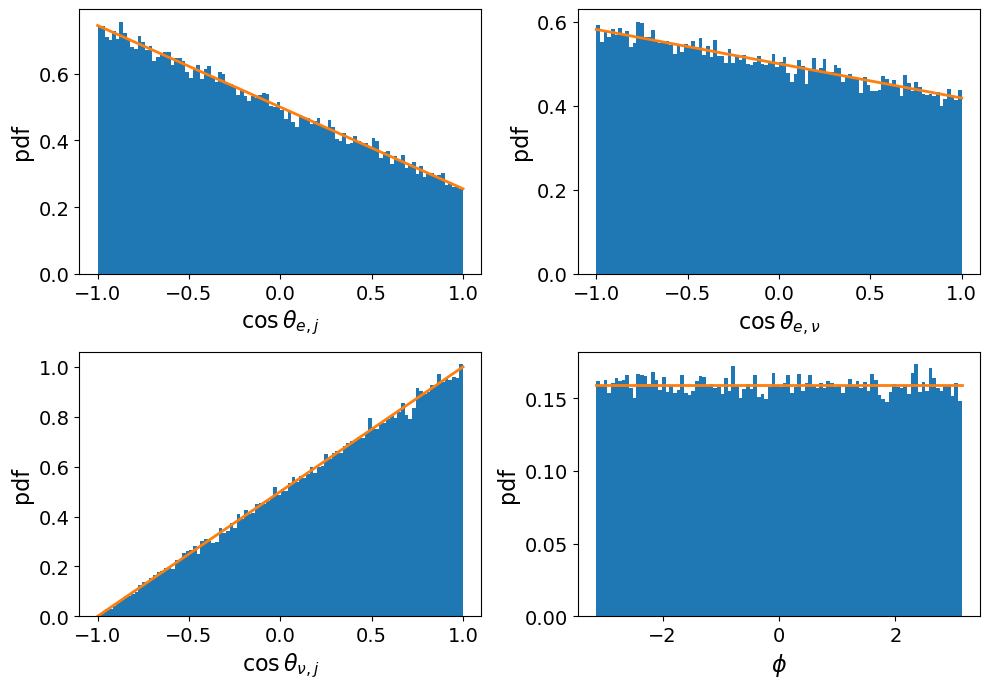

In [5]:
#SM Gamov-Teller but polarised in the -Z direction
#xi = 2

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

SM_60Co_polZneg = Co60_data_analysis("build/60Co_polZneg.txt")
SM_60Co_polZneg.event_mask()
SM_60Co_polZneg.kinematical_data()
SM_60Co_polZneg.kinematical_data_ref()
SM_60Co_polZneg.plot_kin_histograms(fileName="build/60Co_polZneg.txt")
SM_60Co_polZneg.plot_distribution_histograms(showTheory=False,bins=100)
SM_60Co_polZneg.kinematical_data_ref(polDir=np.array([0,0,-1]))
SM_60Co_polZneg.theoretical_dist(SM_coeffs)
SM_60Co_polZneg.plot_distribution_histograms(showTheory=True,bins=100)

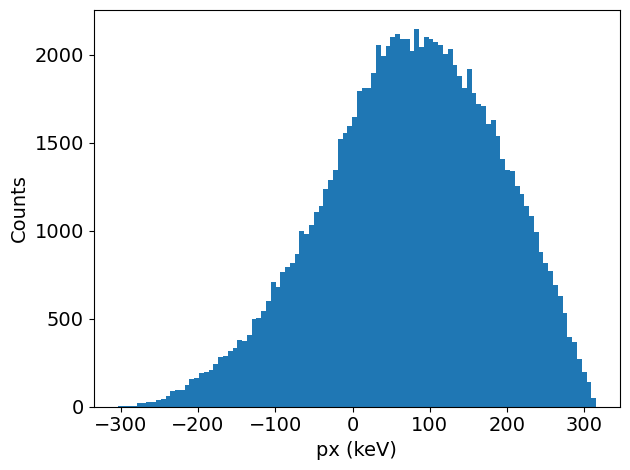

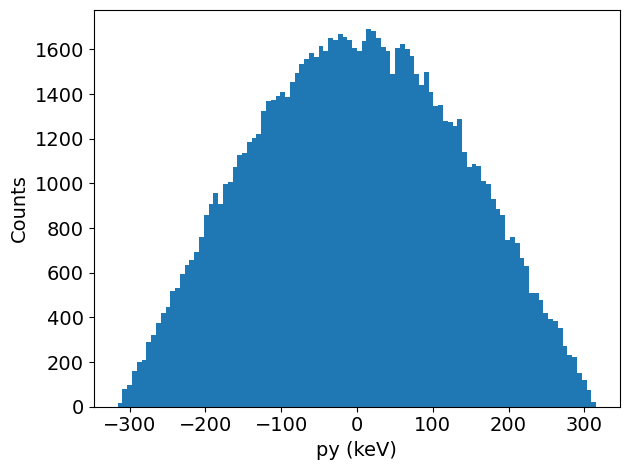

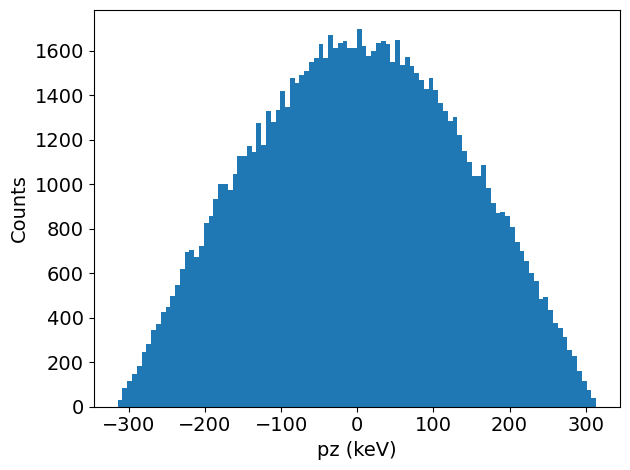

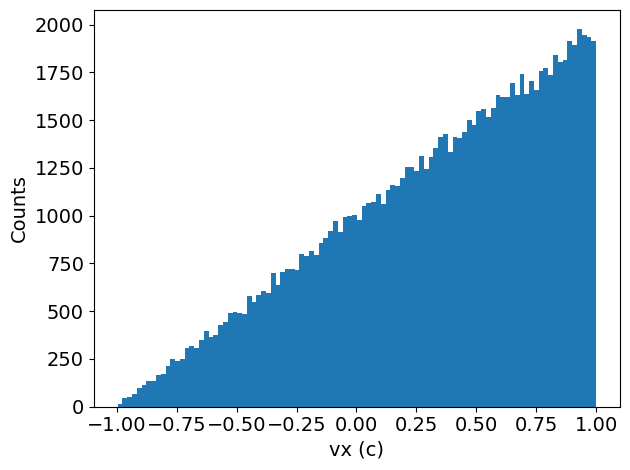

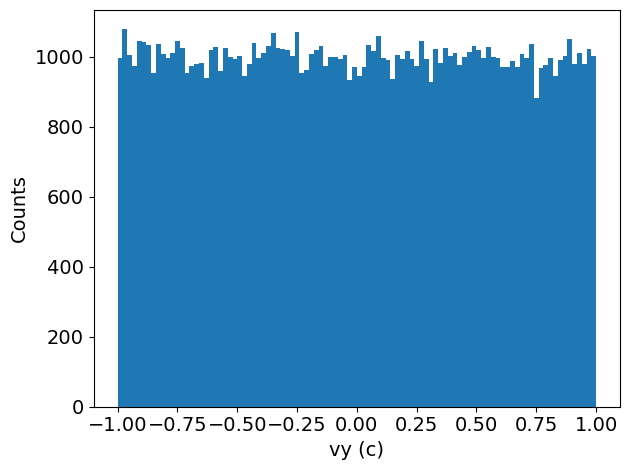

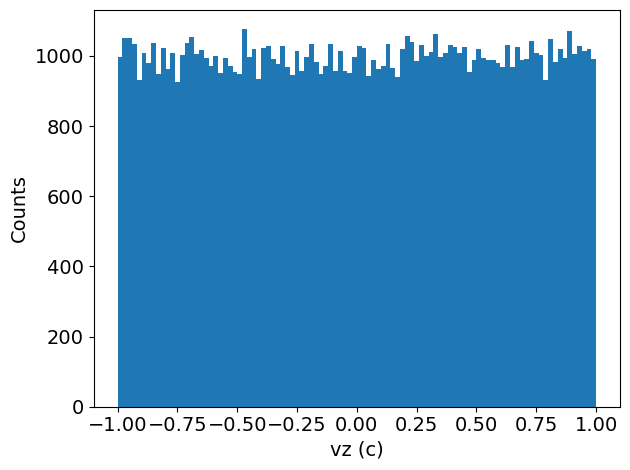

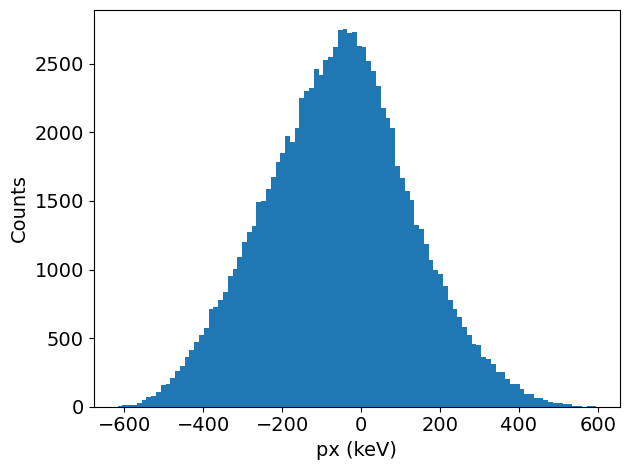

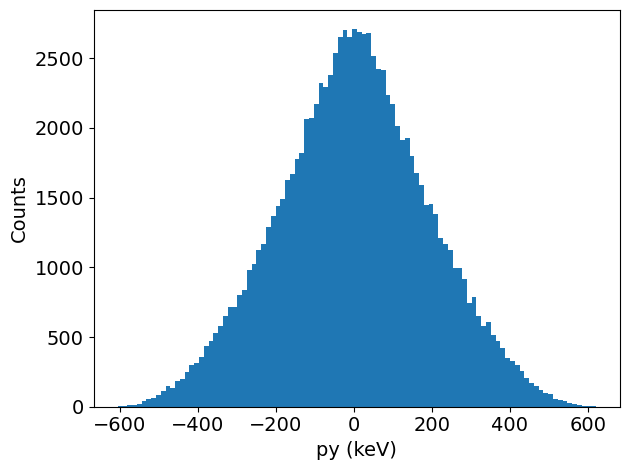

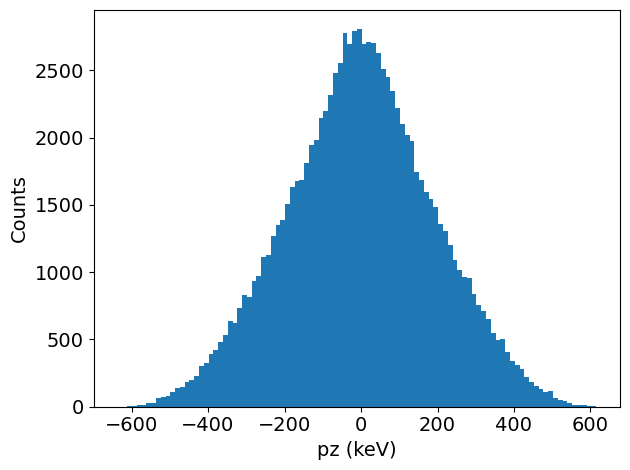

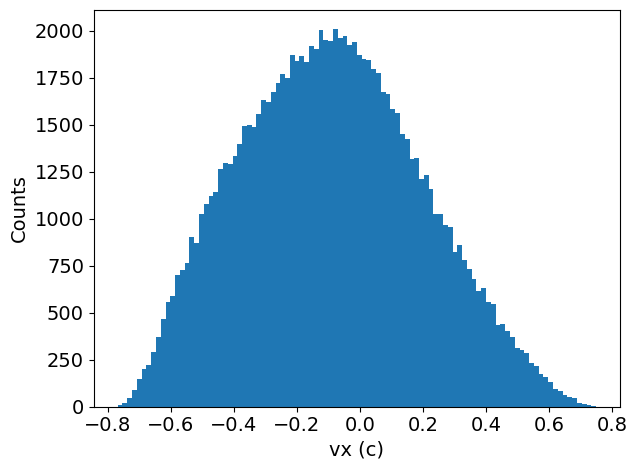

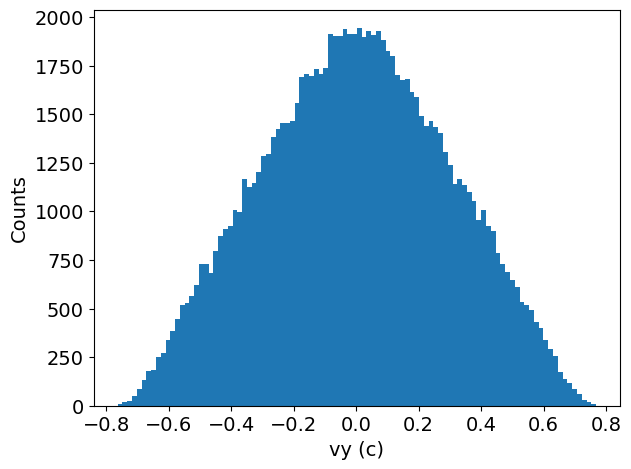

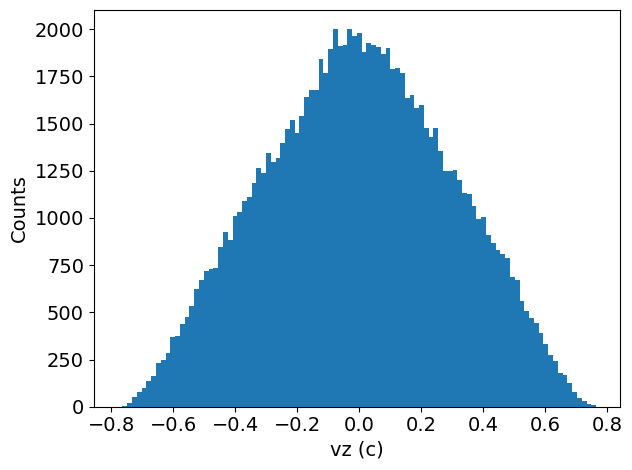

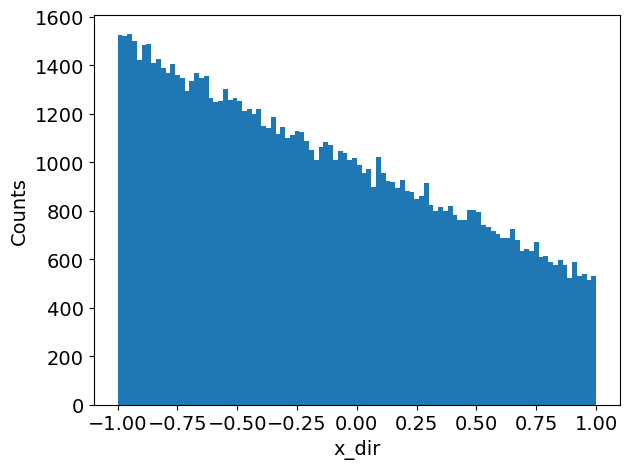

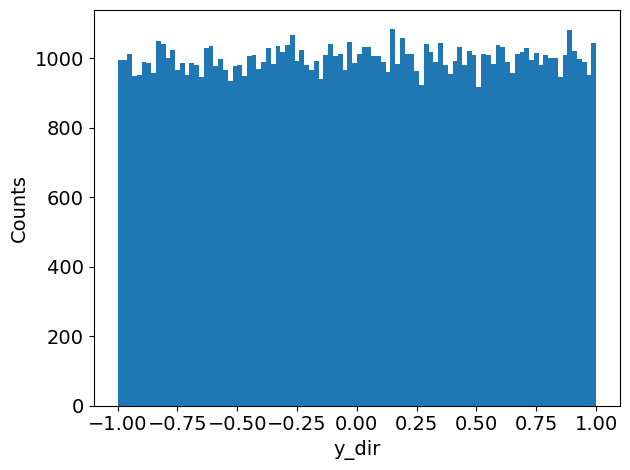

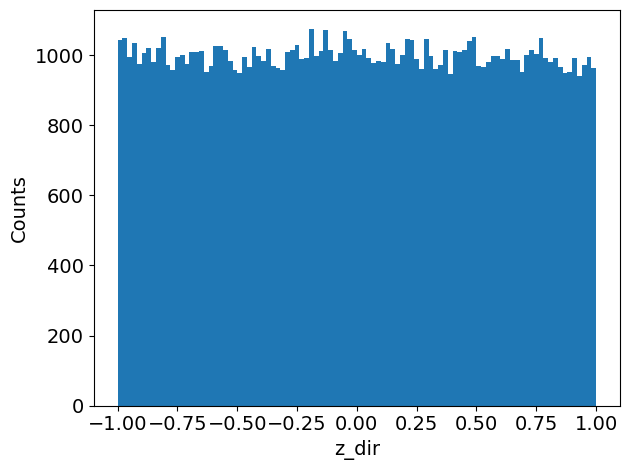

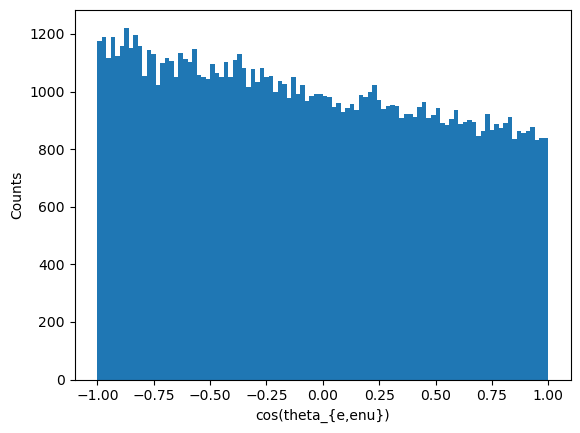

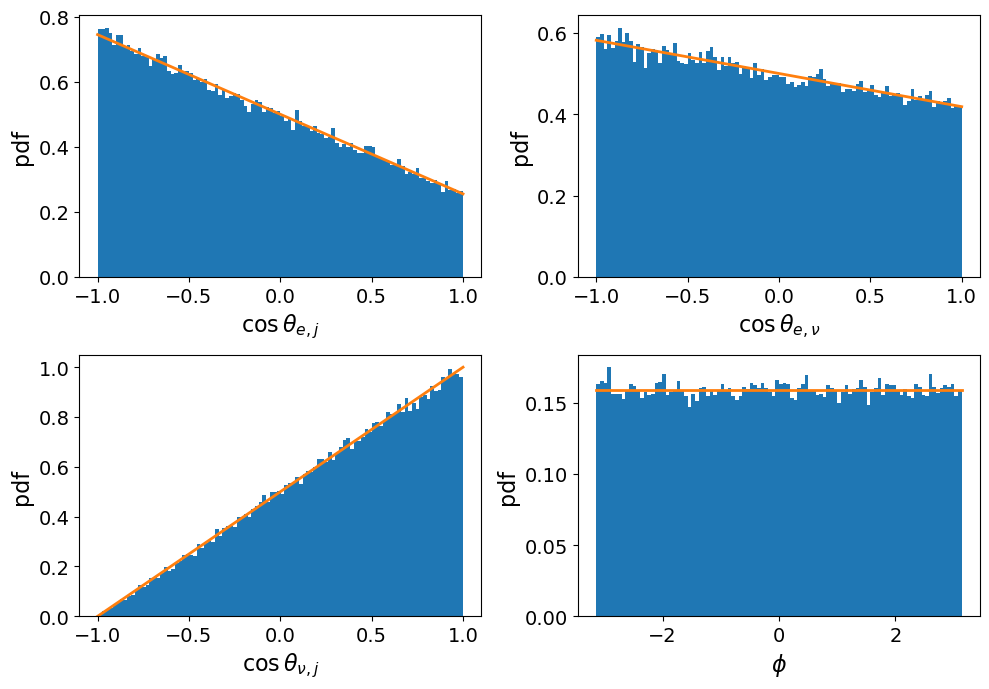

In [6]:
#SM Gamov-Teller but polarised in the X direction
#xi = 2

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

SM_60Co_polXpos = Co60_data_analysis("build/60Co_polXpos.txt")
SM_60Co_polXpos.event_mask()
SM_60Co_polXpos.kinematical_data()
SM_60Co_polXpos.plot_kin_histograms(fileName="build/60Co_polXpos.txt")
SM_60Co_polXpos.kinematical_data_ref(polDir=np.array([1,0,0]))
SM_60Co_polXpos.theoretical_dist(SM_coeffs)
SM_60Co_polXpos.plot_distribution_histograms(showTheory=True,bins=100)

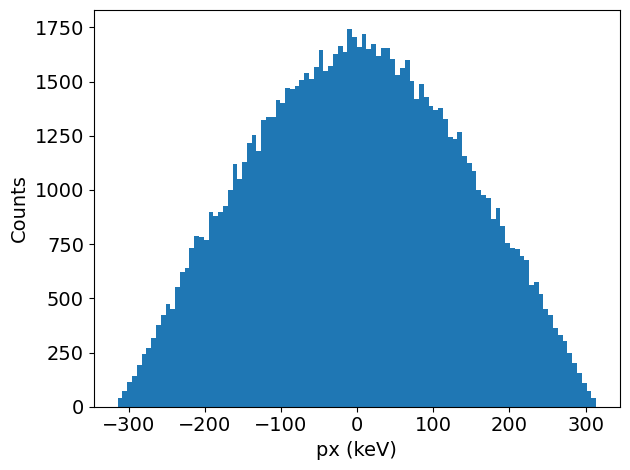

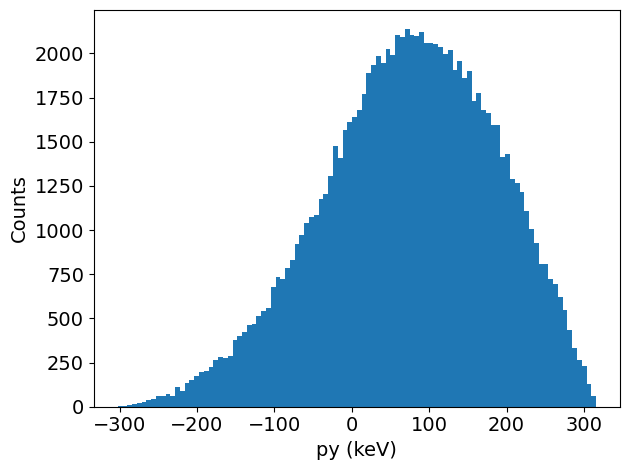

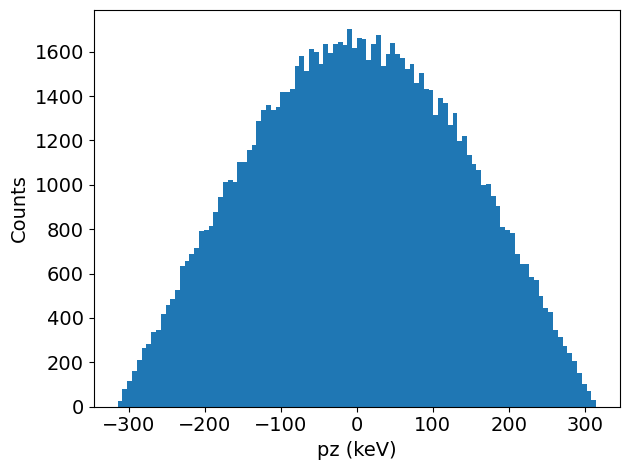

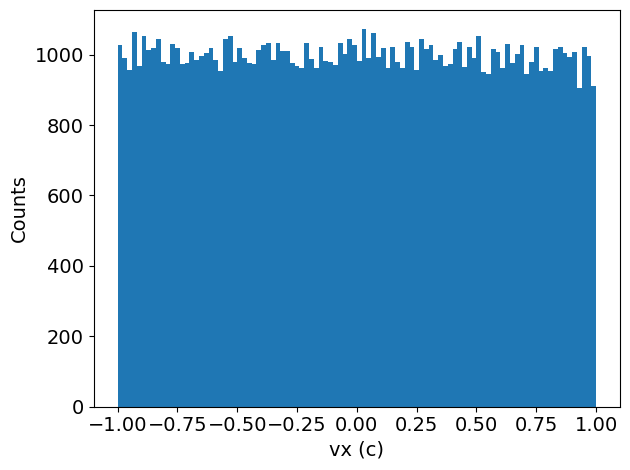

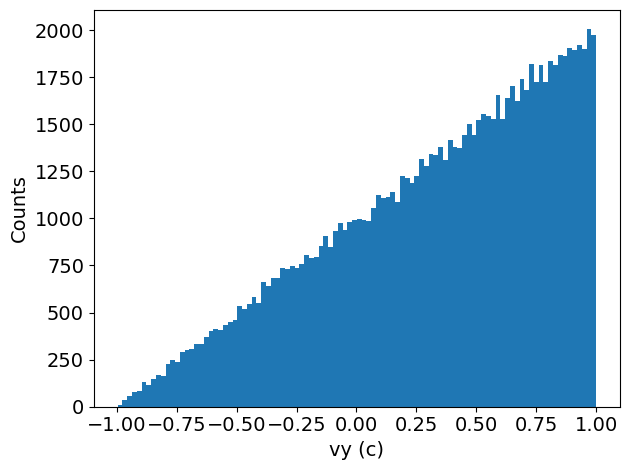

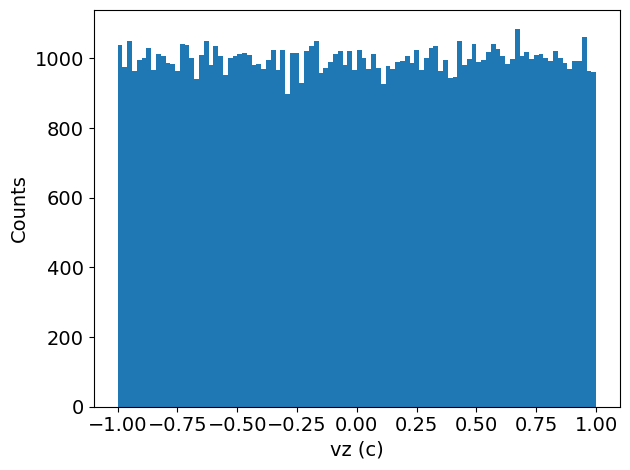

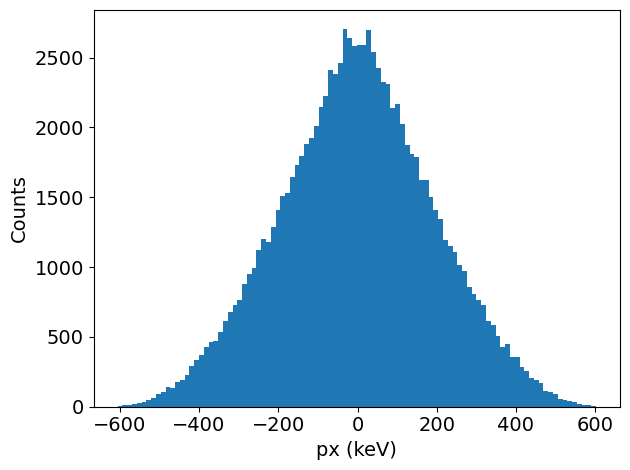

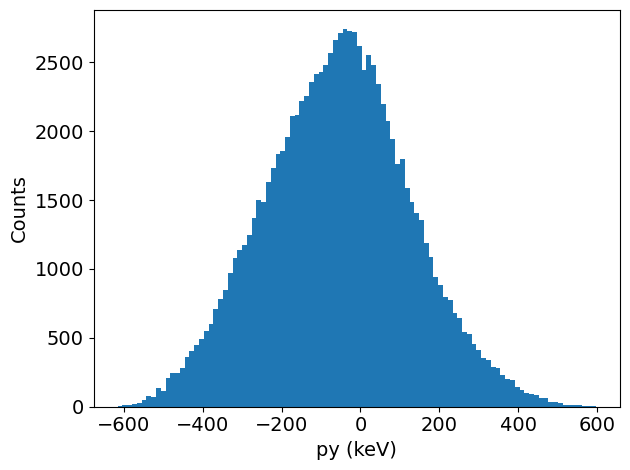

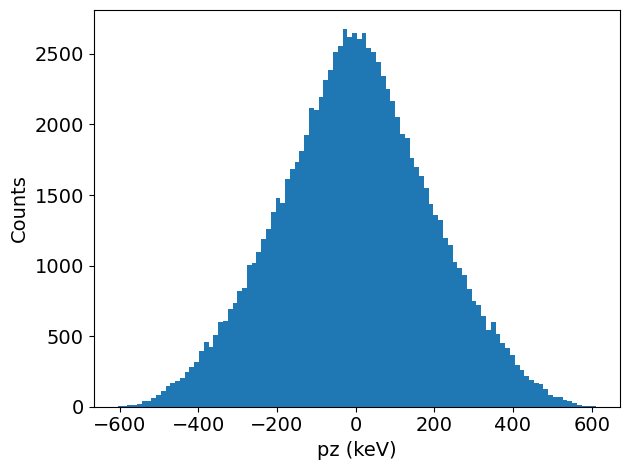

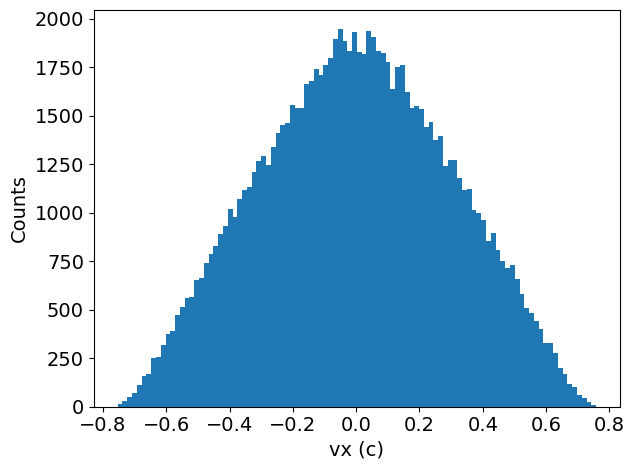

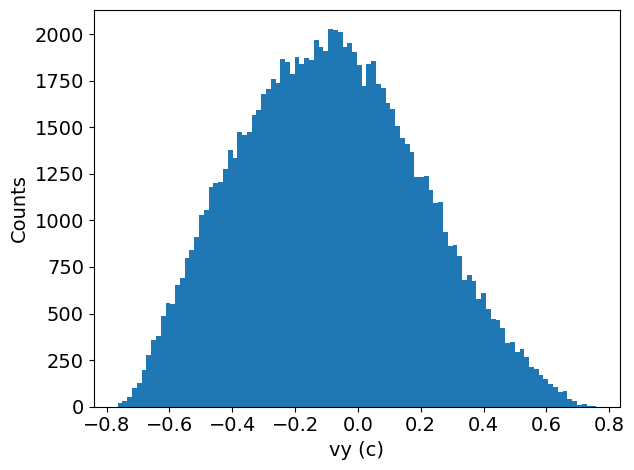

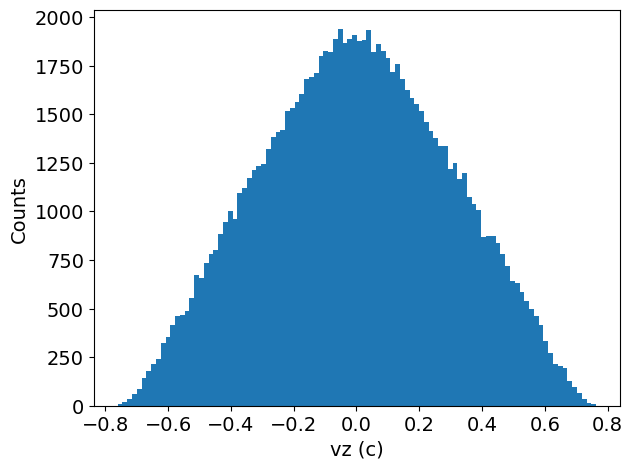

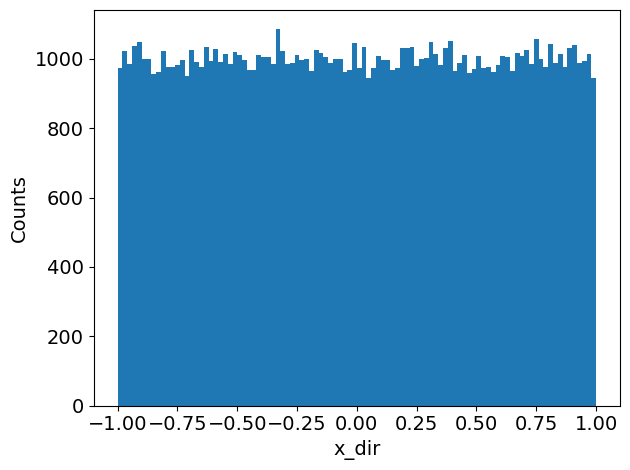

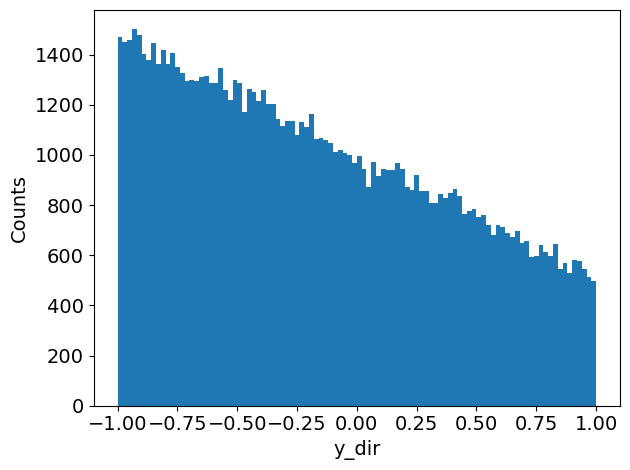

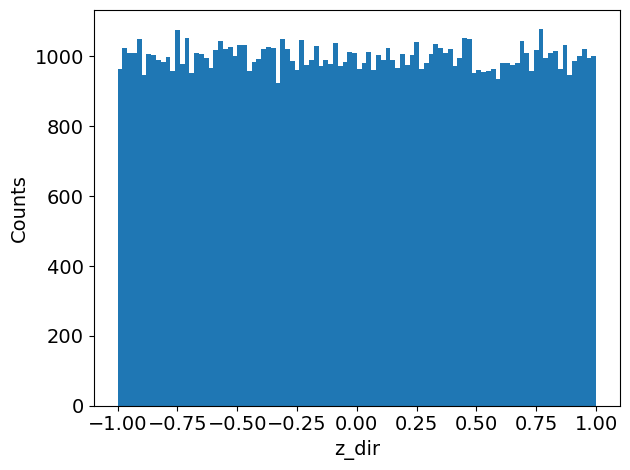

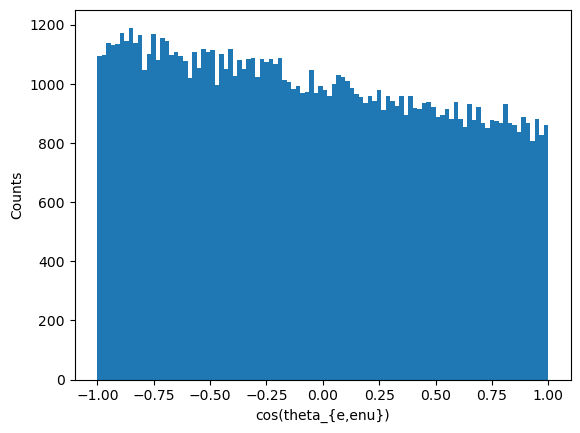

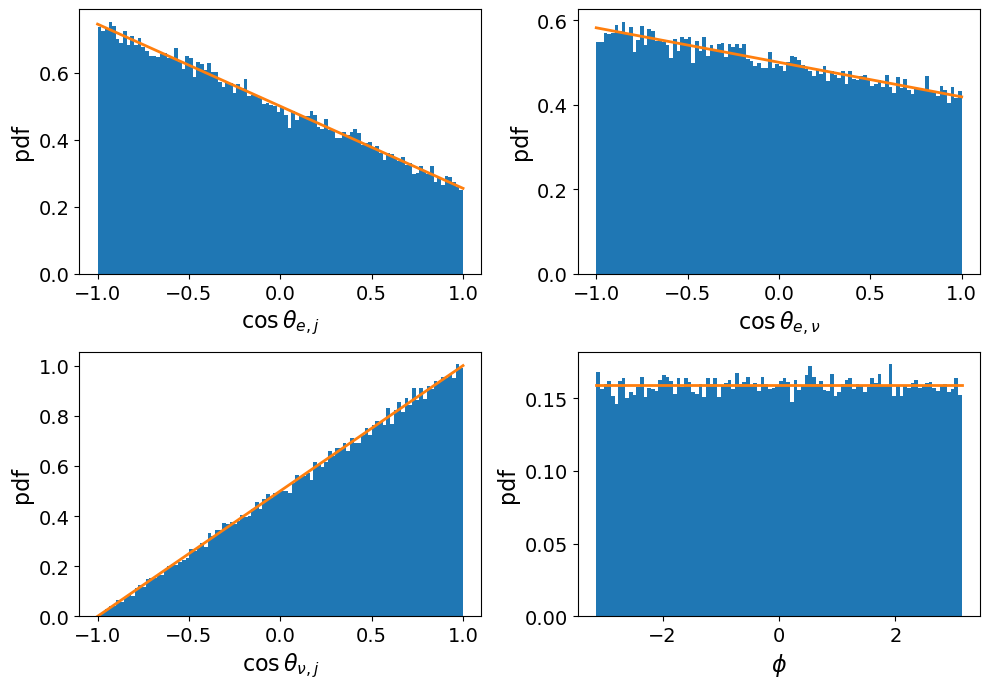

In [7]:
#SM Gamov-Teller but polarised in the Y direction
#xi = 2

alpha = 0.0072973525664
Z = 28 #need Z of daughter nuclei, 60Ni
gamma = np.sqrt(1-Z**2*alpha**2)

SM_60Co_polYpos = Co60_data_analysis("build/60Co_polYpos.txt")
SM_60Co_polYpos.event_mask()
SM_60Co_polYpos.kinematical_data()
SM_60Co_polYpos.plot_kin_histograms(fileName="build/60Co_polYpos.txt")
SM_60Co_polYpos.kinematical_data_ref(polDir=np.array([0,1,0]))
SM_60Co_polYpos.theoretical_dist(SM_coeffs)
SM_60Co_polYpos.plot_distribution_histograms(showTheory=True,bins=100)

100000


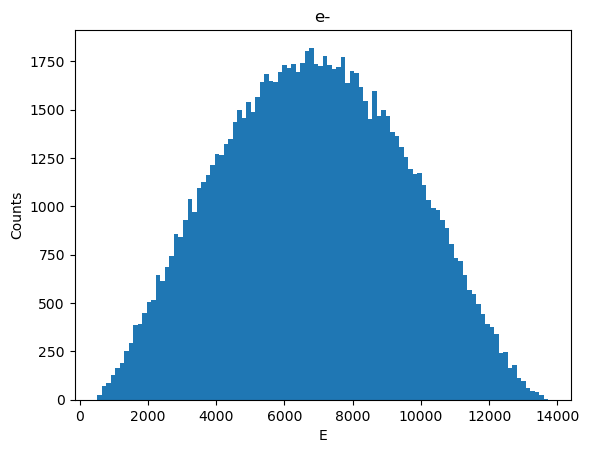

97176


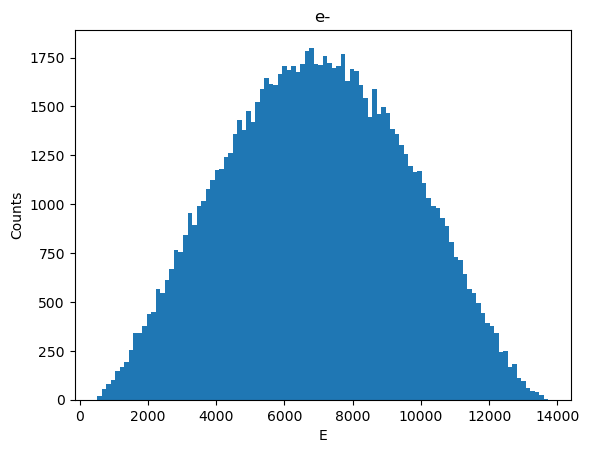

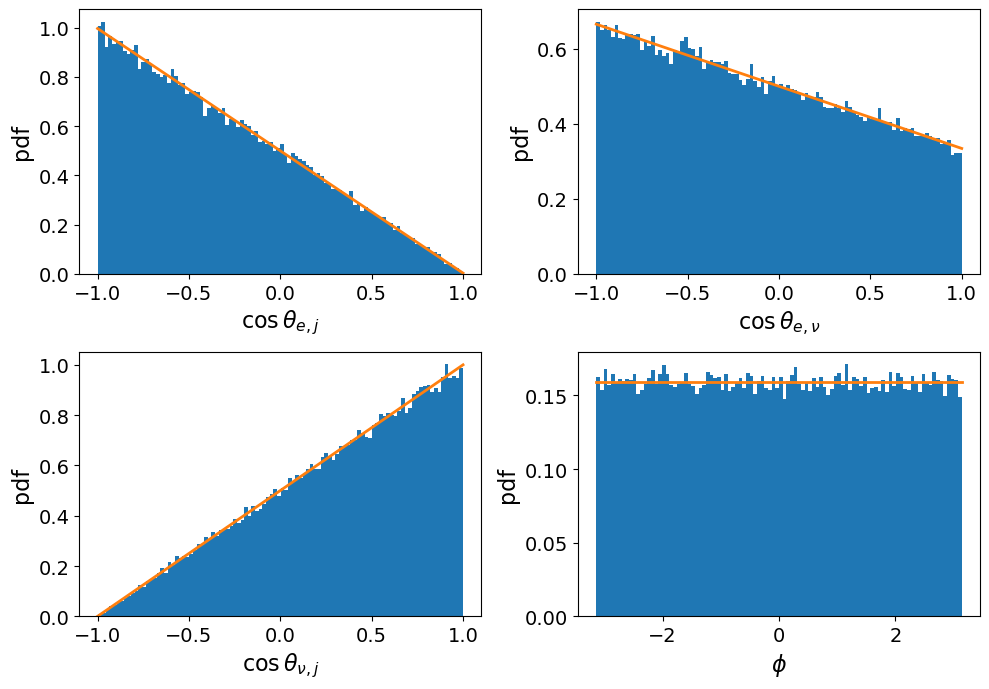

In [16]:
class B12_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, 1)
    def event_mask(self):
        part_events = np.bincount(self.events)
        events_mask = np.arange(part_events.size)[part_events == 3] #12C + e- + enu for the 1+ -> 0+ gs
        self.data = self.data[np.isin(self.events, events_mask),:]
        self.names = self.names[np.isin(self.events, events_mask)]
    
#Standard Model Gamov-Teller

def SM_coeffs(E):
    return (-1/3, 0, 1, -1, 1, 0)
   
SM_12B_polZpos = B12_data_analysis("build/12B_polZpos.txt")
SM_12B_polZpos.kinematical_data()
SM_12B_polZpos.plot_E_dist()
SM_12B_polZpos.event_mask()
SM_12B_polZpos.kinematical_data()
SM_12B_polZpos.plot_E_dist()
SM_12B_polZpos.kinematical_data_ref()
SM_12B_polZpos.theoretical_dist(SM_coeffs)
SM_12B_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="12B_SM_hists")

100000


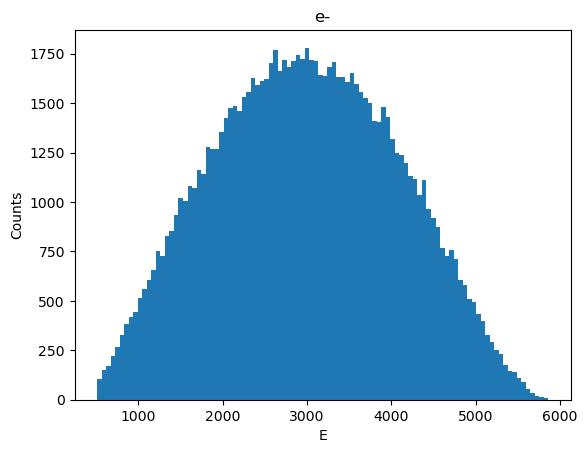

99992


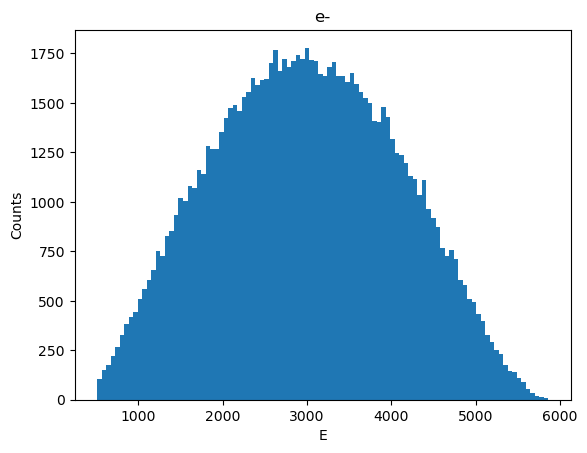

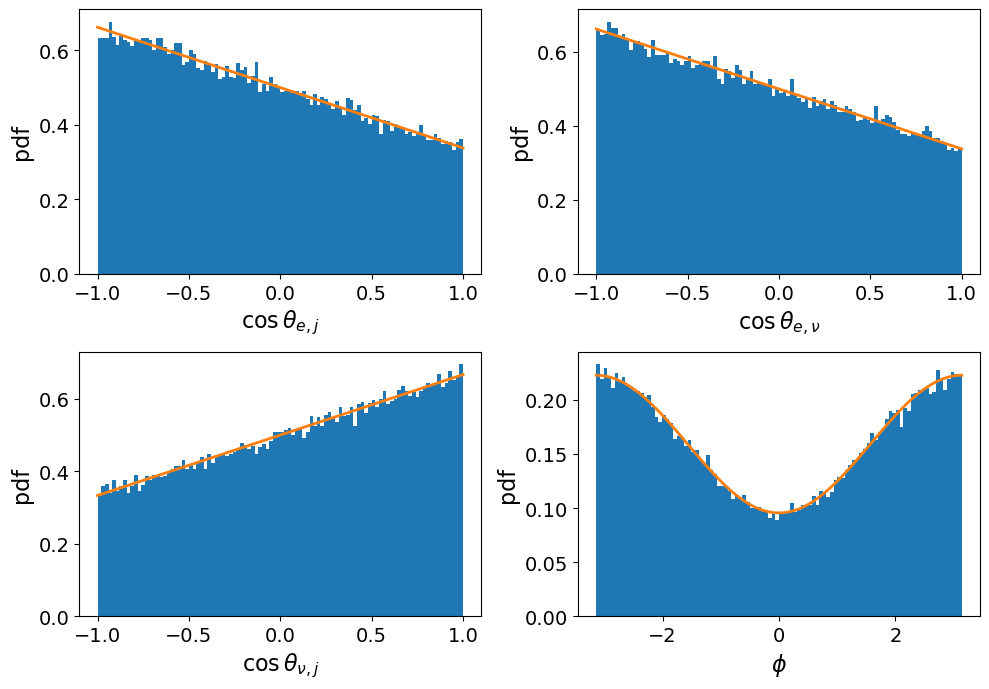

In [17]:
class F20_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, 1)
    def event_mask(self):
        part_events = np.bincount(self.events)
        events_mask = np.arange(part_events.size)[part_events == 4] #20Ne + e- + enu + gamma for the 2+ -> 2+ 1633.67
        self.data = self.data[np.isin(self.events, events_mask),:]
        self.names = self.names[np.isin(self.events, events_mask)]
    
#Standard Model Gamov-Teller

def SM_coeffs(E):
    return (-1/3, 0, -1, -1/3, 1/3, 0)
   
SM_20F_polZpos = F20_data_analysis("build/20F_polZpos.txt")
SM_20F_polZpos.kinematical_data()
SM_20F_polZpos.plot_E_dist()
SM_20F_polZpos.event_mask()
SM_20F_polZpos.kinematical_data()
SM_20F_polZpos.plot_E_dist()
SM_20F_polZpos.kinematical_data_ref()
SM_20F_polZpos.theoretical_dist(SM_coeffs)
SM_20F_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="20F_SM_hists")

400000


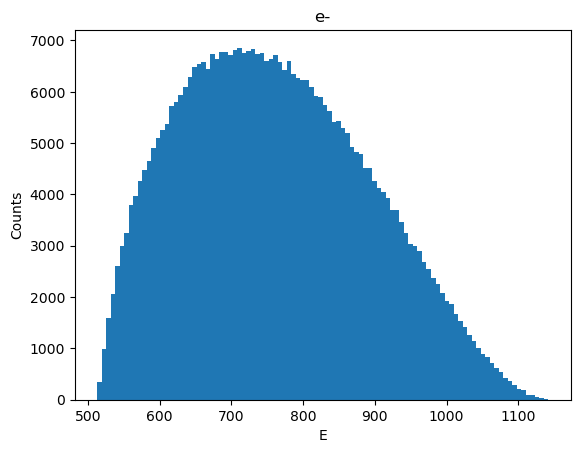

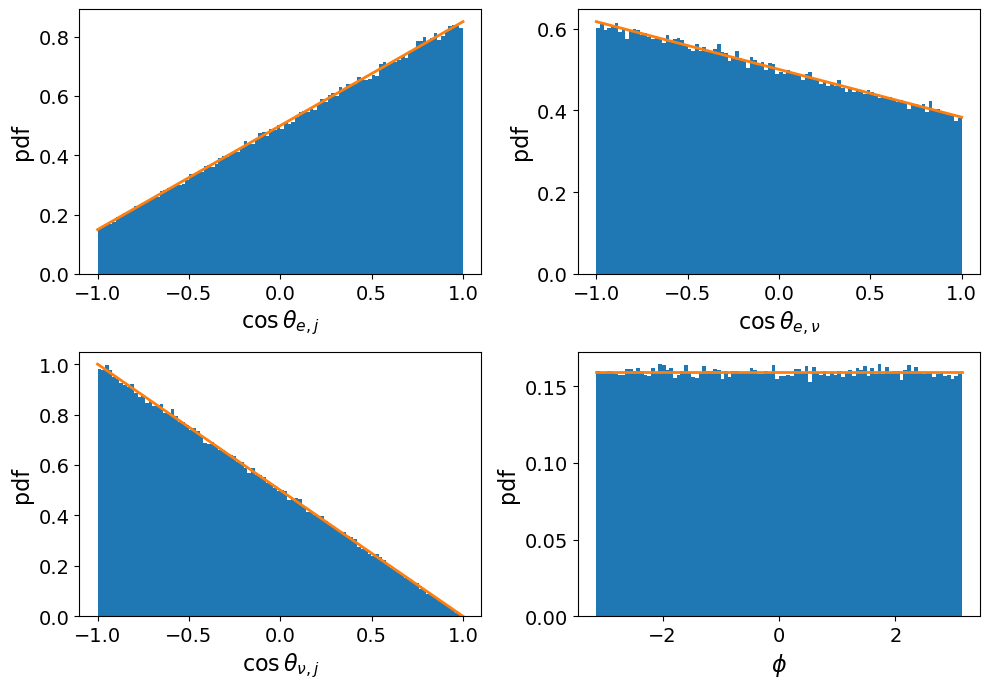

In [18]:
class F18_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, -1)
    #no mask needed, all events are beta+ 1+ -> 0+ gs
    
def SM_coeffs(E):
    return (-1/3, 0, 1, 1, -1, 0)
   
SM_18F_polZpos = F18_data_analysis("build/18F_polZpos.txt")
SM_18F_polZpos.event_mask()
SM_18F_polZpos.kinematical_data()
SM_18F_polZpos.plot_E_dist()
SM_18F_polZpos.kinematical_data_ref()
SM_18F_polZpos.theoretical_dist(SM_coeffs)
SM_18F_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="18F_SM_hists")

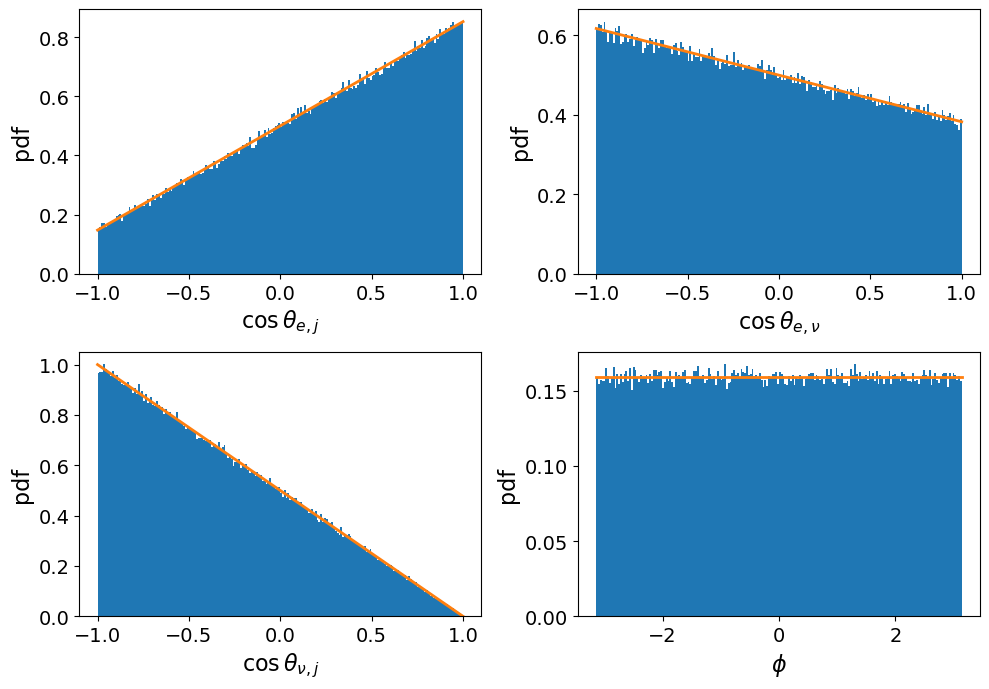

In [19]:
#Gamov-Teller with C_T = C_T' = 1/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 8 #need Z of daughter nuclei, 18O
gamma = np.sqrt(1-Z**2*alpha**2)
    
def CTposRe_coeffs(E):
    a = -1/3*(1/3)
    c = 1/3
    A = 1/3
    b = -2/3*gamma*np.sqrt(2)
    B = 2/3*(-1.5+gamma*mass_e/E*np.sqrt(2))
    return (a, b, c, A, B, 0)
   
CTposRe_18F_polZpos = F18_data_analysis("build/18F_polZpos_ctposRe.txt")
CTposRe_18F_polZpos.event_mask()
CTposRe_18F_polZpos.kinematical_data()
CTposRe_18F_polZpos.kinematical_data_ref()
CTposRe_18F_polZpos.theoretical_dist(CTposRe_coeffs)
CTposRe_18F_polZpos.plot_distribution_histograms(showTheory=True,bins=200,fileName="18F_CTRe_hists")

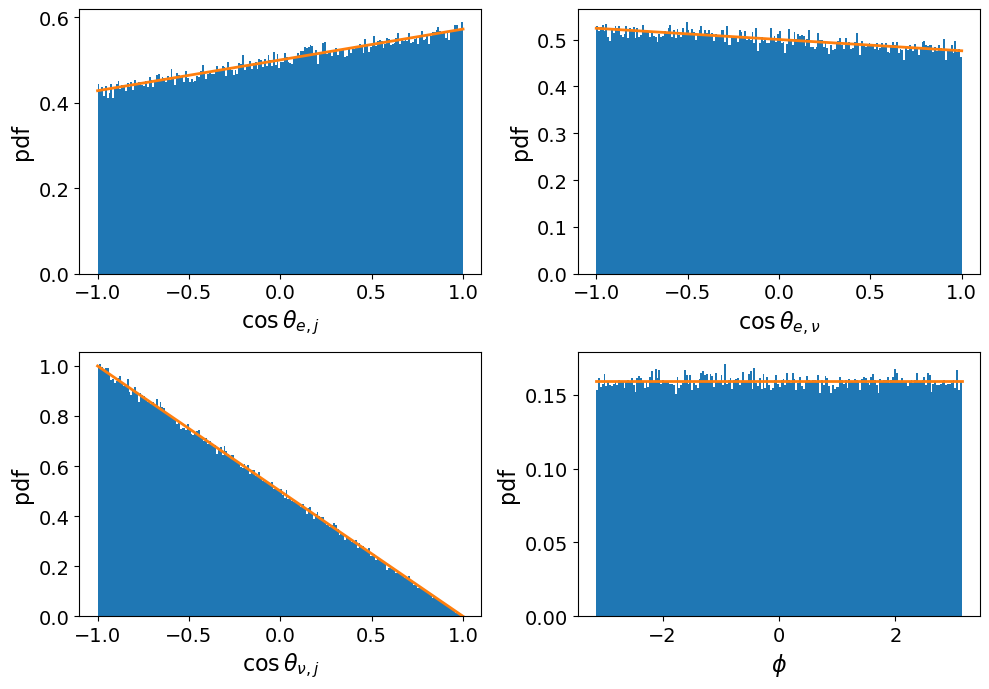

In [12]:
#Gamov-Teller with C_T = C_T' = -1/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 8 #need Z of daughter nuclei, 18O
gamma = np.sqrt(1-Z**2*alpha**2)

def CTnegRe_coeffs(E):
    a = -1/3*(1/3)
    c = 1/3
    A = 1/3
    b = +2/3*gamma*np.sqrt(2)
    B = 2/3*(-1.5-gamma*mass_e/E*np.sqrt(2))
    return (a, b, c, A, B, 0)
   
CTnegRe_18F_polZpos = F18_data_analysis("build/18F_polZpos_ctnegRe.txt")
CTnegRe_18F_polZpos.event_mask()
CTnegRe_18F_polZpos.kinematical_data()
CTnegRe_18F_polZpos.kinematical_data_ref()
CTnegRe_18F_polZpos.theoretical_dist(CTnegRe_coeffs)
CTnegRe_18F_polZpos.plot_distribution_histograms(showTheory=True,bins=200)

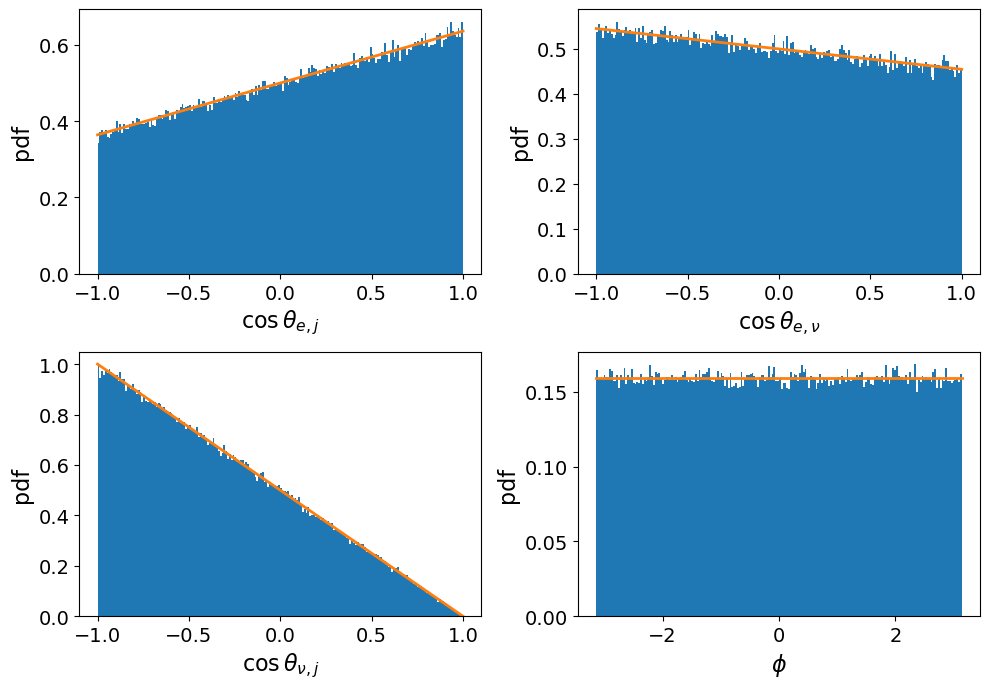

In [21]:
#Gamov-Teller with C_T = C_T' = i/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 8 #need Z of daughter nuclei, 18O
gamma = np.sqrt(1-Z**2*alpha**2)

def CTposIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    a = 1/3*(1/3)*(-1-2*coulombCorr*np.sqrt(2))
    c = -1/3*(-1-2*coulombCorr*np.sqrt(2))
    A = 1/3*(1+2*coulombCorr*np.sqrt(2))
    b = 0
    B = -1
    return (a, b, c, A, B, 0)

CTposIm_18F_polZpos = F18_data_analysis("build/18F_polZpos_ctposIm.txt")
CTposIm_18F_polZpos.event_mask()
CTposIm_18F_polZpos.kinematical_data()
CTposIm_18F_polZpos.kinematical_data_ref()
CTposIm_18F_polZpos.theoretical_dist(CTposIm_coeffs)
CTposIm_18F_polZpos.plot_distribution_histograms(showTheory=True,bins=200,fileName="18F_CTIm_hists")

/tmp/ipykernel_5896/2596415045.py:36: RuntimeWarning: divide by zero encountered in divide
  data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)/sin_el/sin_enu
/tmp/ipykernel_5896/2596415045.py:37: RuntimeWarning: divide by zero encountered in divide
  data_sinphi = z_cross_elenu/sin_el/sin_enu


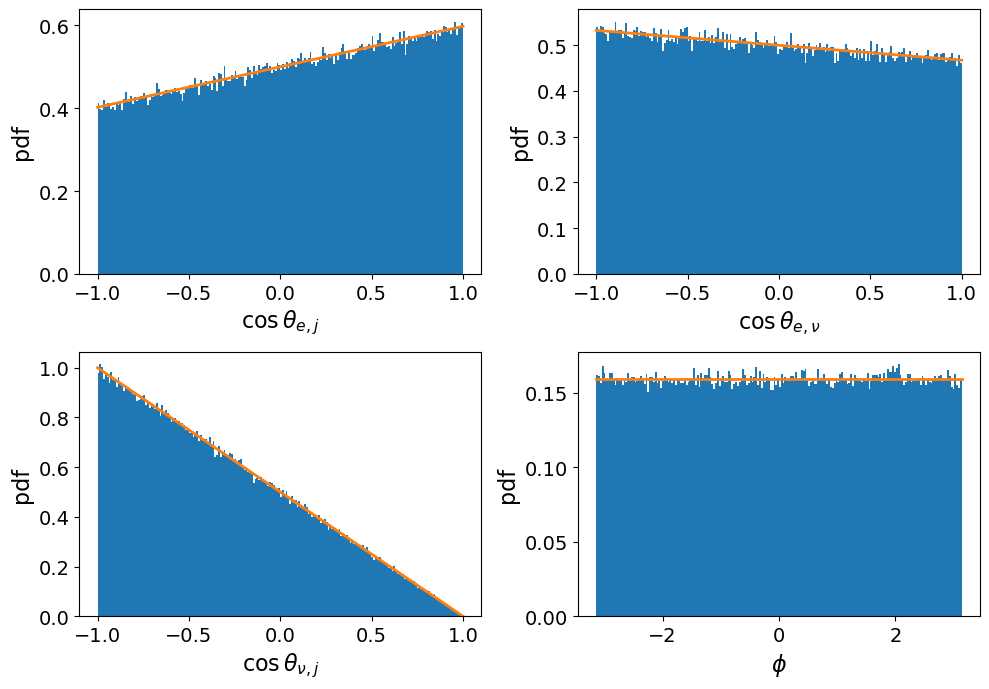

In [14]:
#Gamov-Teller with C_T = C_T' = -i/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 8 #need Z of daughter nuclei, 18O
gamma = np.sqrt(1-Z**2*alpha**2)

def CTnegIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    a = 1/3*(1/3)*(-1+2*coulombCorr*np.sqrt(2))
    c = -1/3*(-1+2*coulombCorr*np.sqrt(2))
    A = 1/3*(1-2*coulombCorr*np.sqrt(2))
    b = 0
    B = -1
    return (a, b, c, A, B, 0)

CTnegIm_18F_polZpos = F18_data_analysis("build/18F_polZpos_ctnegIm.txt")
CTnegIm_18F_polZpos.event_mask()
CTnegIm_18F_polZpos.kinematical_data()
CTnegIm_18F_polZpos.kinematical_data_ref()
CTnegIm_18F_polZpos.theoretical_dist(CTnegIm_coeffs)
CTnegIm_18F_polZpos.plot_distribution_histograms(showTheory=True,bins=200)

/tmp/ipykernel_5896/2596415045.py:36: RuntimeWarning: divide by zero encountered in divide
  data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)/sin_el/sin_enu
/tmp/ipykernel_5896/2596415045.py:37: RuntimeWarning: divide by zero encountered in divide
  data_sinphi = z_cross_elenu/sin_el/sin_enu


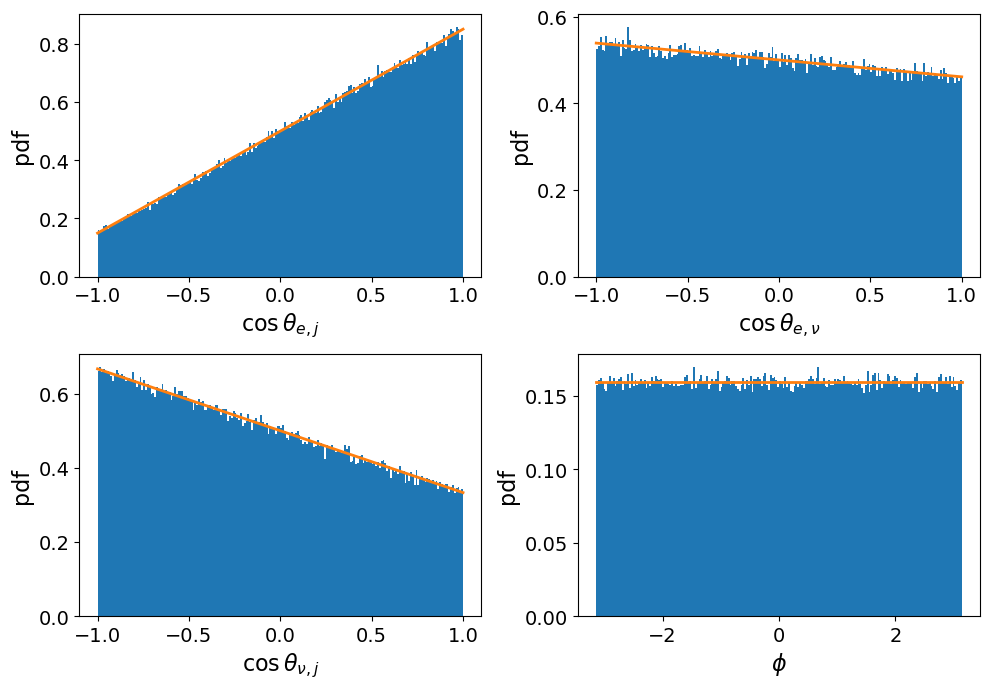

In [20]:
#Gamov-Teller with C_T = C_T' = -i/np.sqrt(2), C_A = C_A' = 1
#xi = 3

alpha = 0.0072973525664
Z = 8 #need Z of daughter nuclei, 18O
gamma = np.sqrt(1-Z**2*alpha**2)

def CTmixIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    a = 1/3*(1/3)*(-1)
    c = -1/3*(-1)
    A = 1
    b = 0
    B = -1/3
    return (a, b, c, A, B, 0)

CTmixIm_18F_polZpos = F18_data_analysis("build/18F_polZpos_ctmixIm.txt")
CTmixIm_18F_polZpos.event_mask()
CTmixIm_18F_polZpos.kinematical_data()
CTmixIm_18F_polZpos.kinematical_data_ref()
CTmixIm_18F_polZpos.theoretical_dist(CTmixIm_coeffs)
CTmixIm_18F_polZpos.plot_distribution_histograms(showTheory=True,bins=200,fileName="18F_CTmix_hists")